# DATA 620, Project 2

### Group 1 Members:

* Mauricio Alarcon
* Sekhar Mekala 
* Aadi Kalloo
* Srinivasa Illapani
* Param Singh 

### Project Requirements

Identify a large 2-node network dataset—you can start with a dataset in a repository.  

1. Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
2. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
3. What can you infer about each of the distinct groups?

You may work in a small group on the project.

Your code and analysis should be delivered in an IPython Notebook by end of day Monday July 3rd. 

## Analyzing Co-Products Using Graph Techniques

The objective of this project is to perform an exploratory analysis of a large 2-node graph consisting of items purchased during a weekend at a major retailer.

We seek to gain insights on:

* Top Rakning Products
* Product Islands/Communities
* Related Products
* Product Recommendations

## Dataset Description

This is a proprietary dataset consisting of 123,716 purchase transactions at a major retailer for a weekend in the month of June. We're representing this transactional dataset ias a bipirtite graph with edges bewtween two node types: Customer Orders (n=16,313) and Products (n=2,167).

The primary focus of analysis is the products network, for which we have a de-identified product name and category. Once we project the graph onto the products, we will be able to analyze co-products and other important metrics.

## Data Loading

In this section we will: 

* Load the data from CSV format into a pandas dataframe 
* Create a Graph using from the pandas dataframe and populate the product attributes


In [1]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy import stats
import numpy as np
from prettytable import PrettyTable
import datetime

In [2]:
prod = pd.read_csv('co-products.csv')
prod.head(n=20)


,order_id,product_id,product_desc,cat_desc
0,10185341,3314604,CHERRIES BULK,CHERRIES
1,10244355,472832,REP2 SUM FRSH HAM SERV DELI,DELI SERVICE MEATS
2,10244547,1013780,REP2 SUM FRESH SODA DELI,DELI BEVERAGE
3,10401922,1921107,MILK PCC RFRG DAIRY,MILK CONVNTNL RFRG DAIRY
4,10411766,2542615,AIR CARE CANDLES,AIR CARE
5,10414438,509272,PASTRIES SUM FRZ BAKERY,BAKERY SWEET GOODS
6,10432453,2876259,KETCHUP,KETCHUP
7,10558119,2892515,APPLESAUCE SINGLE SERVE,PACKAGED FRUIT
8,10615817,1457537,COATED SEASONED POPCORN SNACKS,SALTY SNACKS
9,10658392,790193,EGGPLANT FRH,DRY VEGETABLES


In [3]:
print(prod.shape)

(123716, 4)


Let's now extract the list of procut and order nodes. For the product nodes we will preserve the description and category attributes.

In [4]:
order_nodes  = prod[['order_id']].drop_duplicates()
unique_products  = prod[['product_id','product_desc','cat_desc']].drop_duplicates()
print 'Unique Orders: ' + str(len(order_nodes))
print 'Unique Products: '+ str(len(unique_products))

Unique Orders: 16313
Unique Products: 2167


In [5]:
unique_products = unique_products.merge(prod.groupby(['product_id']).agg(['count'])['order_id'],right_index=True,left_on='product_id')#.tolist()

In [6]:
product_nodes = unique_products.product_id.unique
product_nodes_attr = unique_products[['product_desc','cat_desc']].to_dict().values()

And now, let's create the Order-Product graph:

In [7]:
K = nx.from_pandas_dataframe(prod,'order_id','product_id',create_using=nx.DiGraph())

In [8]:
print(nx.info(K))

Name: 
Type: DiGraph
Number of nodes: 18480
Number of edges: 123716
Average in degree:   6.6946
Average out degree:   6.6946


In [9]:
len(K.edges())

123716

and populate the product attributes

In [10]:
nx.set_node_attributes(K, 'type', pd.Series('order', index=order_nodes.order_id).to_dict())
nx.set_node_attributes(K, 'type', pd.Series('product', index=unique_products.product_id).to_dict())

x = unique_products.product_desc
x.index = unique_products.product_id
nx.set_node_attributes(K, 'product_desc', x.to_dict())


x = unique_products.cat_desc
x.index = unique_products.product_id
nx.set_node_attributes(K, 'cat_desc', x.to_dict())


# Analizing Product Purchases

In this case, let's look at the Order-Product graph and see what insights we can get about product purchases.

Let's calculate and compare the degree centrality and pagerank on the order-products graph and dump the results into a pandas dataframe:

In [11]:
# Rank elements of network using degree centrality
d = nx.degree(K)
# set the node attribute
nx.set_node_attributes(K, 'degree_op', d)

# Rank elements of network using degree centrality
dc = nx.degree_centrality(K)
# set the node attribute
nx.set_node_attributes(K, 'degree_centrality_op', dc)

# Rank elements of network using pagerank
pr = nx.pagerank(K)
# set the node attribute
nx.set_node_attributes(K, 'pagerank_op', pr)


Let's now look at the category rankings for the products, looking at the top 20 by degree centrality and pagerank: 

In [12]:
#pull out all the nodes and convert to pandas DF
nodes = K.nodes(data=True)
df = pd.DataFrame([node[1] for node in nodes])
df.id = [node[0] for node in nodes]
df.sort_values(by='degree_centrality_op',ascending=False).head(20)


,cat_desc,degree_centrality_op,degree_op,pagerank_op,product_desc,type
6724,BANANAS,0.115807,2140,0.005717,BANANAS BULK,product
11489,MILK CONVNTNL RFRG DAIRY,0.097516,1802,0.005038,MILK PCC RFRG DAIRY,product
14085,BERRIES,0.074301,1373,0.003328,STRAWBERRIES FRH,product
186,SALTY SNACKS,0.060014,1109,0.003290,POTATO CHIPS,product
4653,EGGS CONVNTNL RFRG DAIRY,0.059311,1096,0.002449,EGGS CONVNTNL RFRG DAIRY,product
14977,BREAD SS,0.056713,1048,0.002547,EVERYDAY BREAD SS,product
9854,BUNS AND ROLLS BREAD SS,0.053628,991,0.002519,HAMBURGER HOTDOG BUNS BREAD SS,product
14674,SHREDS AND CHUNKS PKGD CHEESE,0.052330,967,0.001692,SHREDDED PACKAGED CHEESE,product
8375,SALTY SNACKS,0.052221,965,0.002346,NACHOS ROUND TORTILLA CHIPS,product
10752,ICE CREAM,0.048704,900,0.003340,ICE CREAM,product


From the table above, we can see that certain poroducts have a high degree centrality such as Banannas, milk and berries. This means that these are top-ranking products independent of anything else, it does not discriminate if the customer bought these alone or in conjunction with something else

In [13]:
df[df.type=='product'].sort_values(by='pagerank_op',ascending=False).head(20)

,cat_desc,degree_centrality_op,degree_op,pagerank_op,product_desc,type
5973,CIGARETTES,0.029872,552,0.011349,CARTON SINGLE PACK CIGARETTES,product
8097,CARBONATED SOFT DRINKS,0.039829,736,0.009241,SGL SRV BTLE CARB SFT DRINK,product
6724,BANANAS,0.115807,2140,0.005717,BANANAS BULK,product
17320,DELI BEVERAGE,0.018724,346,0.005383,REP2 SUM FRESH SODA DELI,product
506,ABOVE PREMIUM QUALITY BEER,0.043888,811,0.005365,CRAFT BEER,product
14763,ALTERNATIVE BEVERAGE,0.022079,408,0.005333,ENERGY DRINKS,product
11489,MILK CONVNTNL RFRG DAIRY,0.097516,1802,0.005038,MILK PCC RFRG DAIRY,product
14787,WATER,0.019698,364,0.004594,WATER SINGLE SERVE,product
5003,ICE,0.016289,301,0.004038,ICE,product
12788,FRANCHISE BEVERAGE,0.008767,162,0.003497,SUM ICED LATTE TEA FRAPPUCCINO,product


The PageRank method reveals interesting patterns such as CIGARETTES. As we know from pagerank, it tends to favor products referred from nodes with a low number of edges. These are products that tend to come from single item baskets. Let's see the order history:

In [14]:
prod[prod.order_id.isin(prod[prod.product_desc=='CARTON SINGLE PACK CIGARETTES'].order_id.tolist())].sort_values(by='order_id')

,order_id,product_id,product_desc,cat_desc
73685,10017612,109159,CARTON SINGLE PACK CIGARETTES,CIGARETTES
73872,10031259,109159,CARTON SINGLE PACK CIGARETTES,CIGARETTES
16043,10037147,109159,CARTON SINGLE PACK CIGARETTES,CIGARETTES
13401,10047857,109159,CARTON SINGLE PACK CIGARETTES,CIGARETTES
60080,10051055,109159,CARTON SINGLE PACK CIGARETTES,CIGARETTES
52356,10051059,109159,CARTON SINGLE PACK CIGARETTES,CIGARETTES
119782,10051060,109159,CARTON SINGLE PACK CIGARETTES,CIGARETTES
111216,10057235,109159,CARTON SINGLE PACK CIGARETTES,CIGARETTES
105648,10075200,109159,CARTON SINGLE PACK CIGARETTES,CIGARETTES
41596,10083395,1051427,READY TO DRINK COFFEE,ALTERNATIVE BEVERAGE


and a histogram of number of other products in basket:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116cf6110>]], dtype=object)

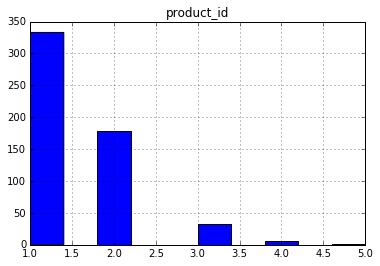

In [15]:
prod[prod.order_id.isin(prod[prod.product_desc=='CARTON SINGLE PACK CIGARETTES'].order_id.tolist())].groupby('order_id').count()[[0]].hist()

As we can see in the above table, cigarretes tend to be purchased in single-item trips, with over 60%

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116b82490>]], dtype=object)

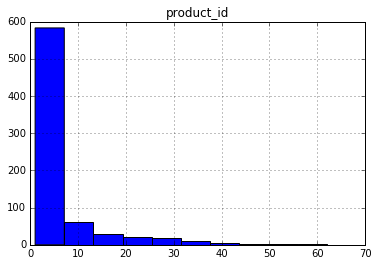

In [16]:
prod[prod.order_id.isin(prod[prod.product_desc=='SGL SRV BTLE CARB SFT DRINK'].order_id.tolist())].groupby('order_id').count()[[0]].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1179be990>]], dtype=object)

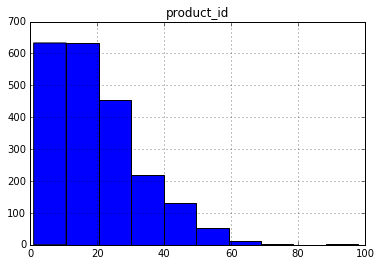

In [17]:
prod[prod.order_id.isin(prod[prod.product_desc=='BANANAS BULK'].order_id.tolist())].groupby('order_id').count()[[0]].hist()

### Centrality by Product Category

In [18]:
df[df.type=='product'].groupby(['cat_desc']).mean().sort_values(by='pagerank_op',ascending=False).head(20)

,degree_centrality_op,degree_op,pagerank_op
cat_desc,,,
CIGARETTES,0.029872,552.000000,0.011349
BANANAS,0.115807,2140.000000,0.005717
DELI BEVERAGE,0.018724,346.000000,0.005383
ALTERNATIVE BEVERAGE,0.018093,334.333333,0.003184
WATER,0.025128,464.333333,0.003108
CHERRIES,0.047135,871.000000,0.002641
MILK CONVNTNL RFRG DAIRY,0.050300,929.500000,0.002637
EGGS CONVNTNL RFRG DAIRY,0.059311,1096.000000,0.002449
ICE,0.008415,155.500000,0.002148


# Analyzing Co-Products

Now, let's look at the product-product projection of the graph and see what we can get by using the Islands method. Before that, let's convert the graph to undirected and obtain the Product-Product projection

In [19]:
from networkx.algorithms import bipartite

K_ud = K.to_undirected()

# and get the connected components
P = bipartite.weighted_projected_graph(K_ud, unique_products.product_id.tolist())
P.edges(data=True)[0:5]

P_components = list(nx.connected_component_subgraphs(P))

d = nx.degree(P,weight='weight')
# set the node attribute
nx.set_node_attributes(P, 'degree_op', d)

# Rank elements of network using degree centrality
dc = nx.degree_centrality(P)
# set the node attribute
nx.set_node_attributes(P, 'degree_centrality_op', dc)

# Rank elements of network using pagerank
pr = nx.pagerank(P,weight='weight')
# set the node attribute
nx.set_node_attributes(P, 'pagerank_op', pr)


#G = bipartite.weighted_projected_graph(K_ud, bottom_nodes)
#G.edges(data=True)[0:5]


In [20]:
print(nx.info(P))

Name: 
Type: Graph
Number of nodes: 2167
Number of edges: 288221
Average degree: 266.0092


As a reference, let's see how many single/multi product baskets we have:


In [21]:
basket_sizes = prod.groupby('order_id').size()
print "Total Number of Orders: "+str(len(basket_sizes))
print "Orders With Only 1 Product: "+str(len(basket_sizes[basket_sizes==1]))
print "Orders With More Than 1 Product: "+str(len(basket_sizes[basket_sizes>1]))

Total Number of Orders: 16313
Orders With Only 1 Product: 4470
Orders With More Than 1 Product: 11843


## Product Islands

In [22]:
def trim_edges( g, weight = 1): 
    g2 = nx.Graph() 
    for f, to, edata in g.edges( data = True): 
        if edata['weight'] > weight: 
            g2. add_edge( f, to, edata) 
    return g2

def island_method( g, iterations = 5): 
    weights = [edata['weight'] for f, to, edata in g.edges( data = True)] 
    mn = int( min( weights)) +50
    mx = int( max( weights)) 
    #compute the size of the step, so we get a reasonable step in iterations 
    step = int(( mx-mn)/ iterations) 
    return [[ threshold, trim_edges( g, threshold)] for threshold in [5,20,50,200,350,450,600,1000]]#range( mn, mx, step)]

In [23]:
#for i in [island_method(p) for p in P_components]
islands = island_method(P_components[0],4)


In [24]:
def displayIslands(islands):
    j=1
    for i in islands:
        # print the threshold level, size of the graph, and number of connected components ... \
        I_cc =  list( nx.connected_component_subgraphs( i[1]))
        print i[ 0], len( i[ 1]), len(I_cc)
        n = j*100+1
        j+=1
        for I in I_cc:
            labels = {}
            for node in I.nodes(data=True):
                labels.update({node[0]:unique_products[unique_products.product_id==node[0]].product_desc.tolist()[0]})

            weights = [ie[2].get('weight')*50 for ie in I.edges(data=True)] 

            plt.figure(figsize=(20,20))
            pos = None
            if (len( I)>200):
                nx.draw(I, node_size=weights, with_labels=True, labels=labels)
            else: 
                pos=nx.drawing.circular_layout(I)
                nx.draw_networkx(I, pos, cmap=plt.get_cmap('jet'), node_size=weights, with_labels=True, labels=labels,alpha=0.5, k=0.5)
            plt.title("Weight="+str(i[0])+", Node Count="+str(len(I))+", Island Id="+str(n)+"\n"+nx.info(I))
            n+=1




In [25]:
islands[0]

[5, <networkx.classes.graph.Graph at 0x103f97290>]

5 939 9
20 485 3
50 221 1
200 29 1
350 7 1
450 4 1
600 2 1
1000 0 0


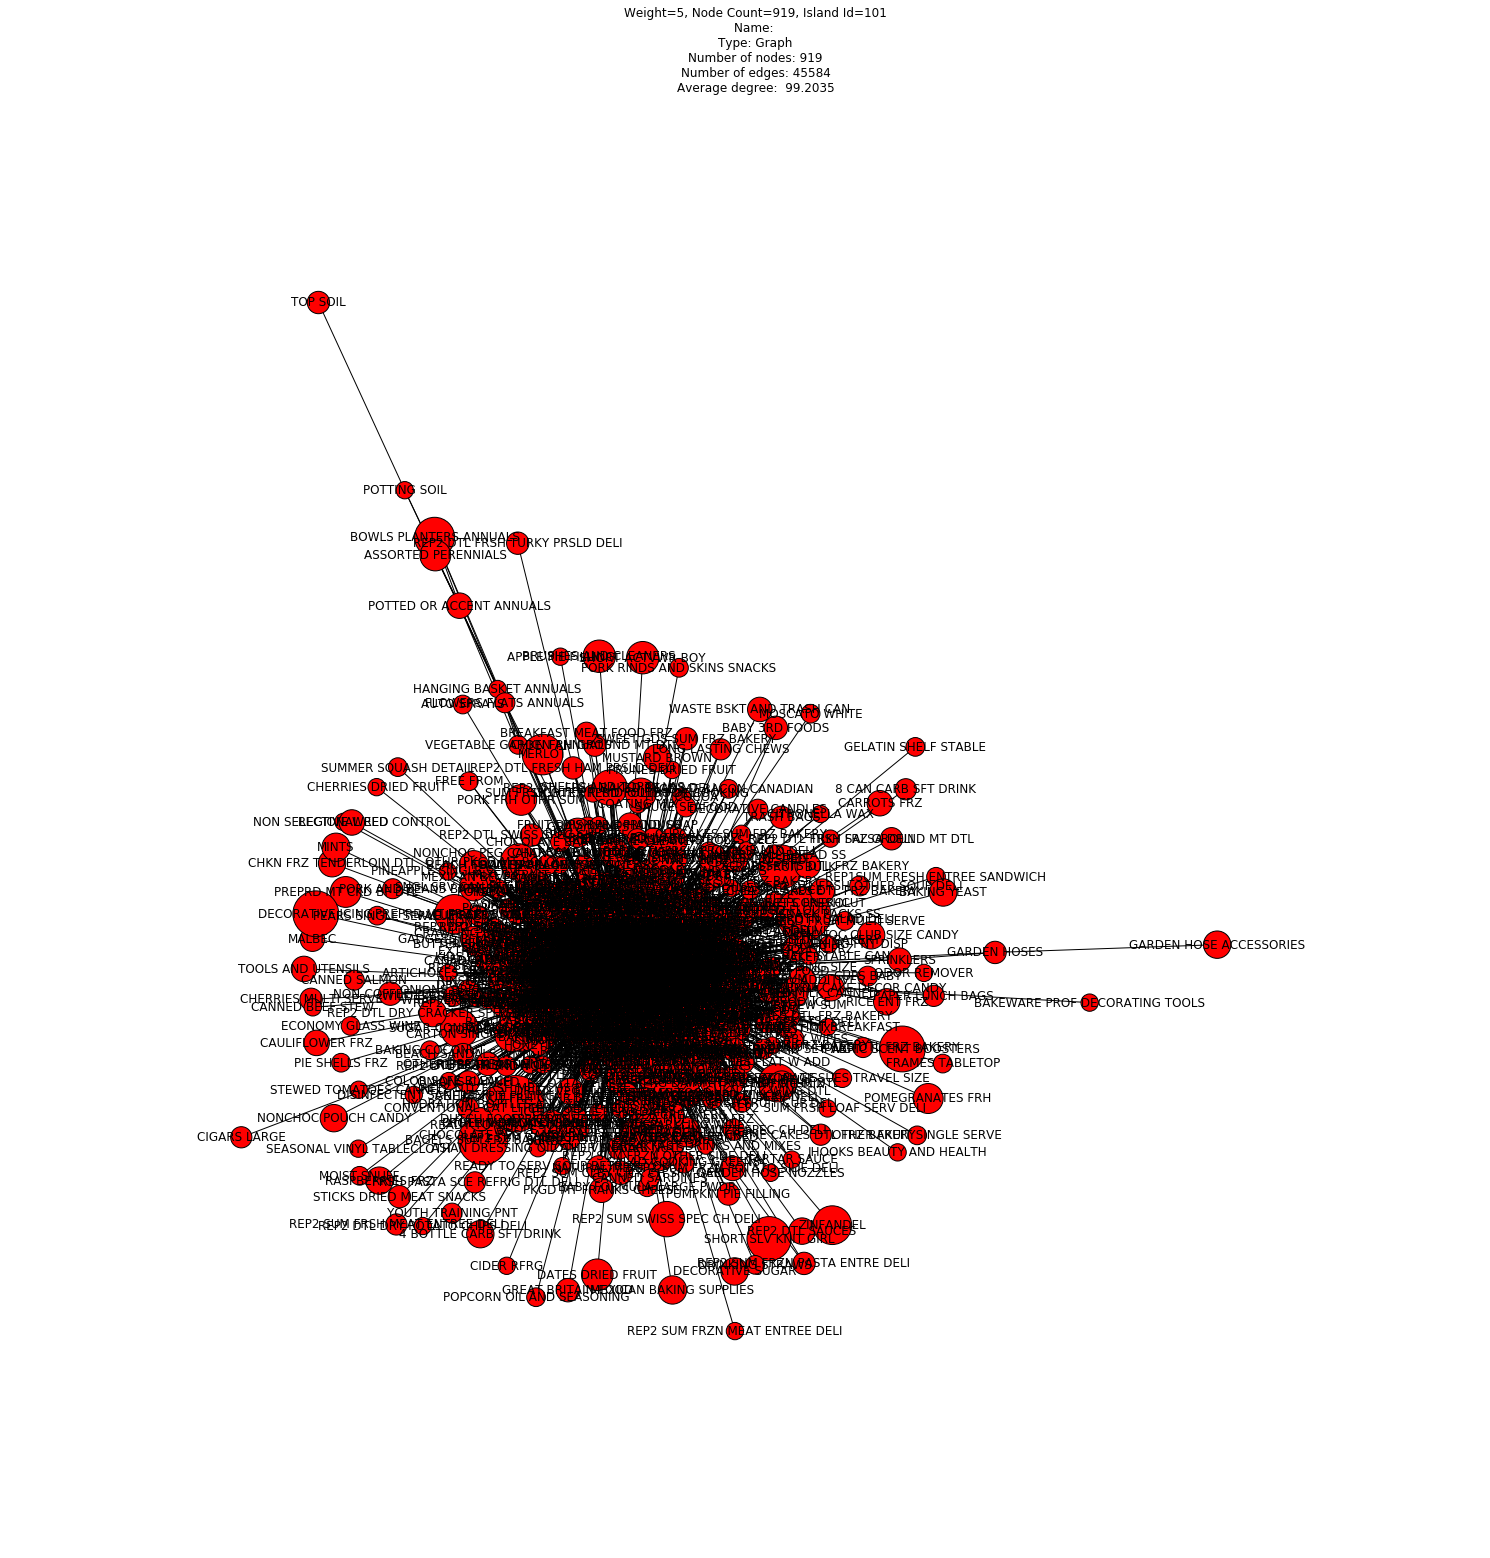

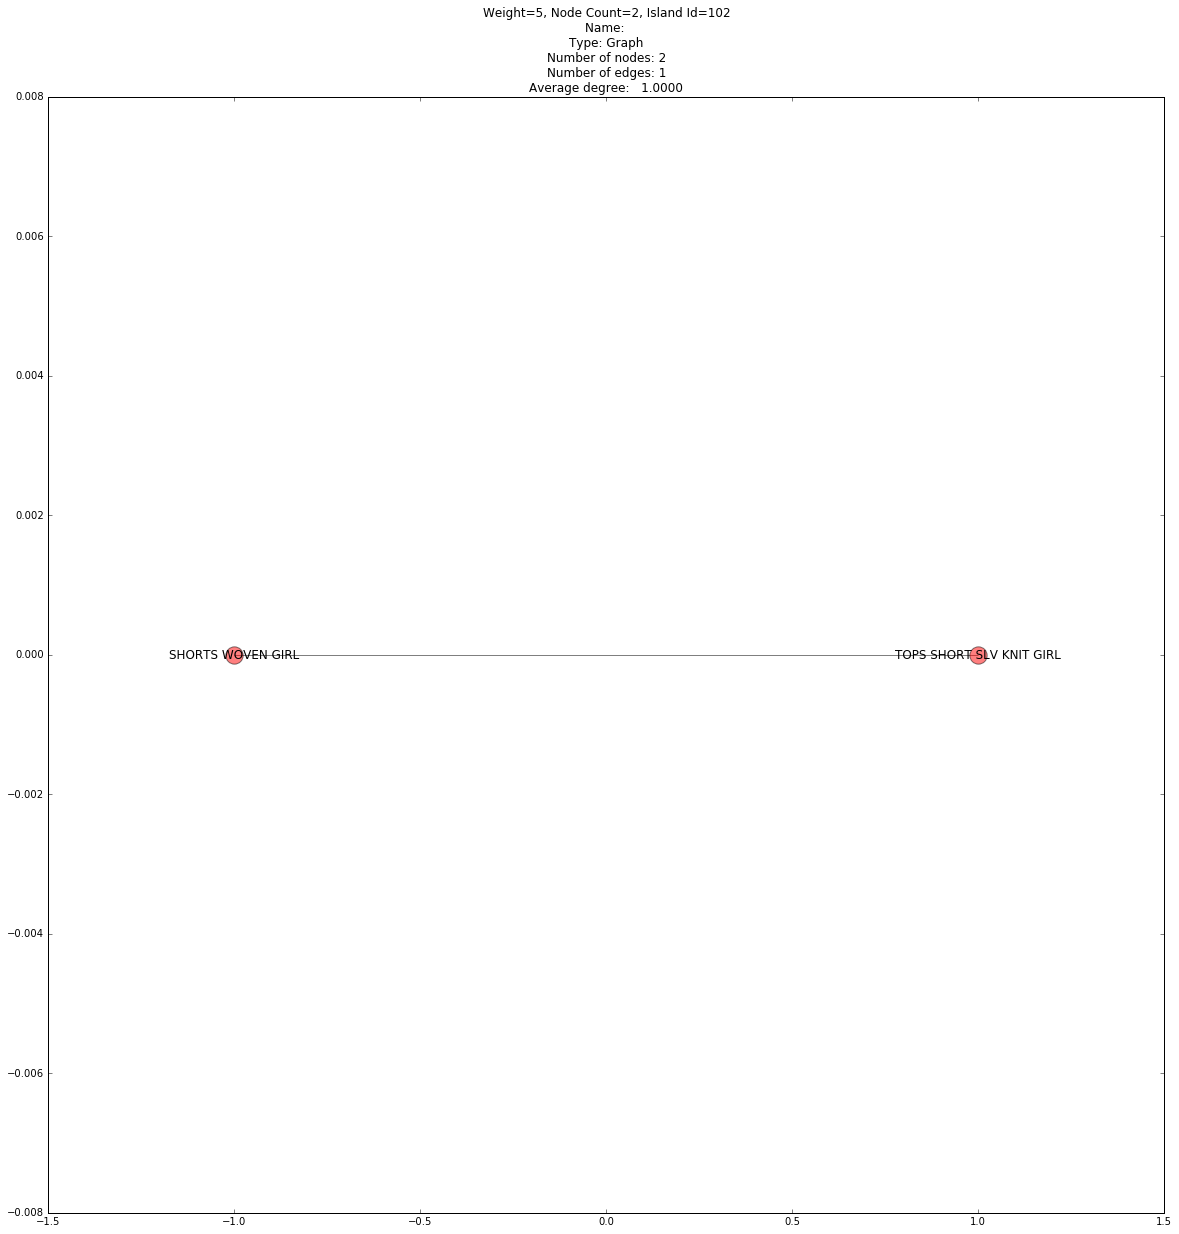

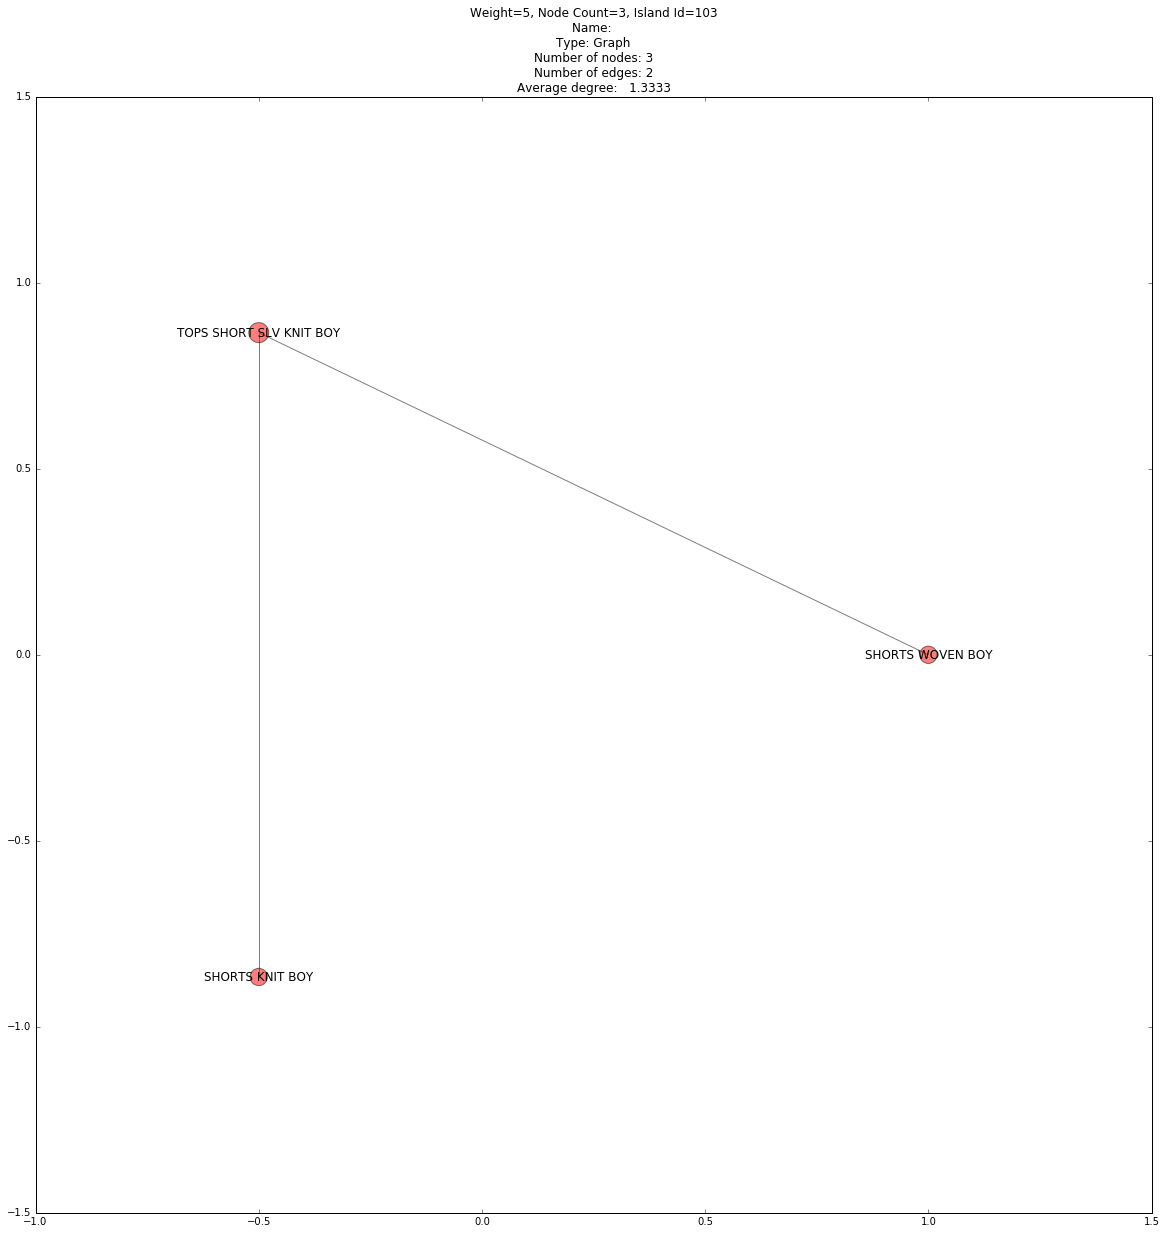

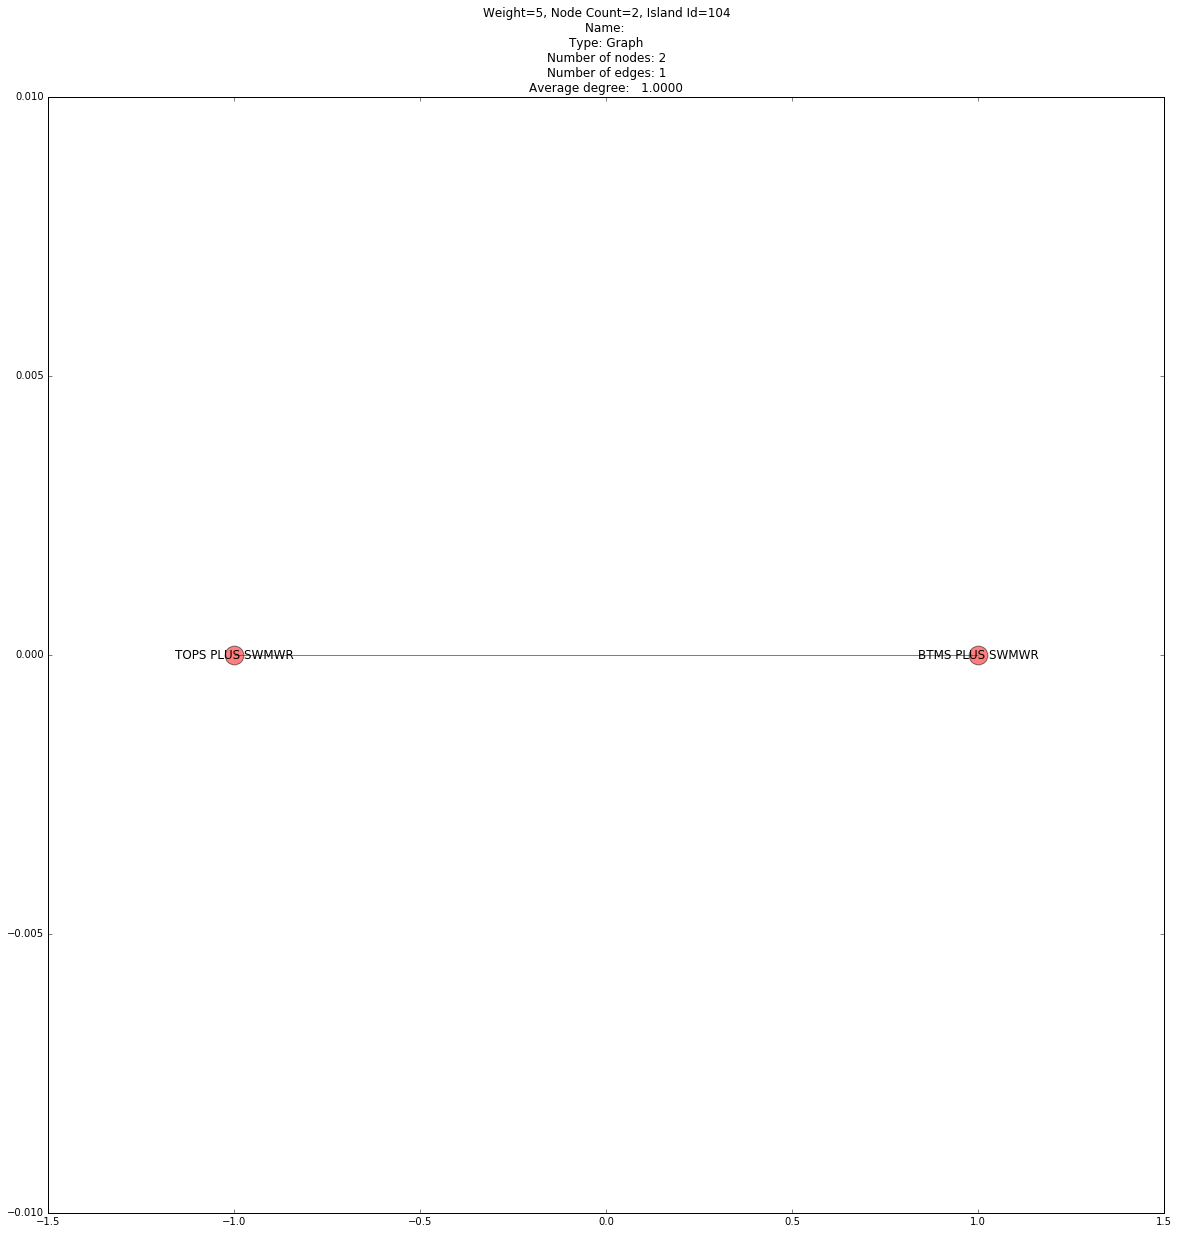

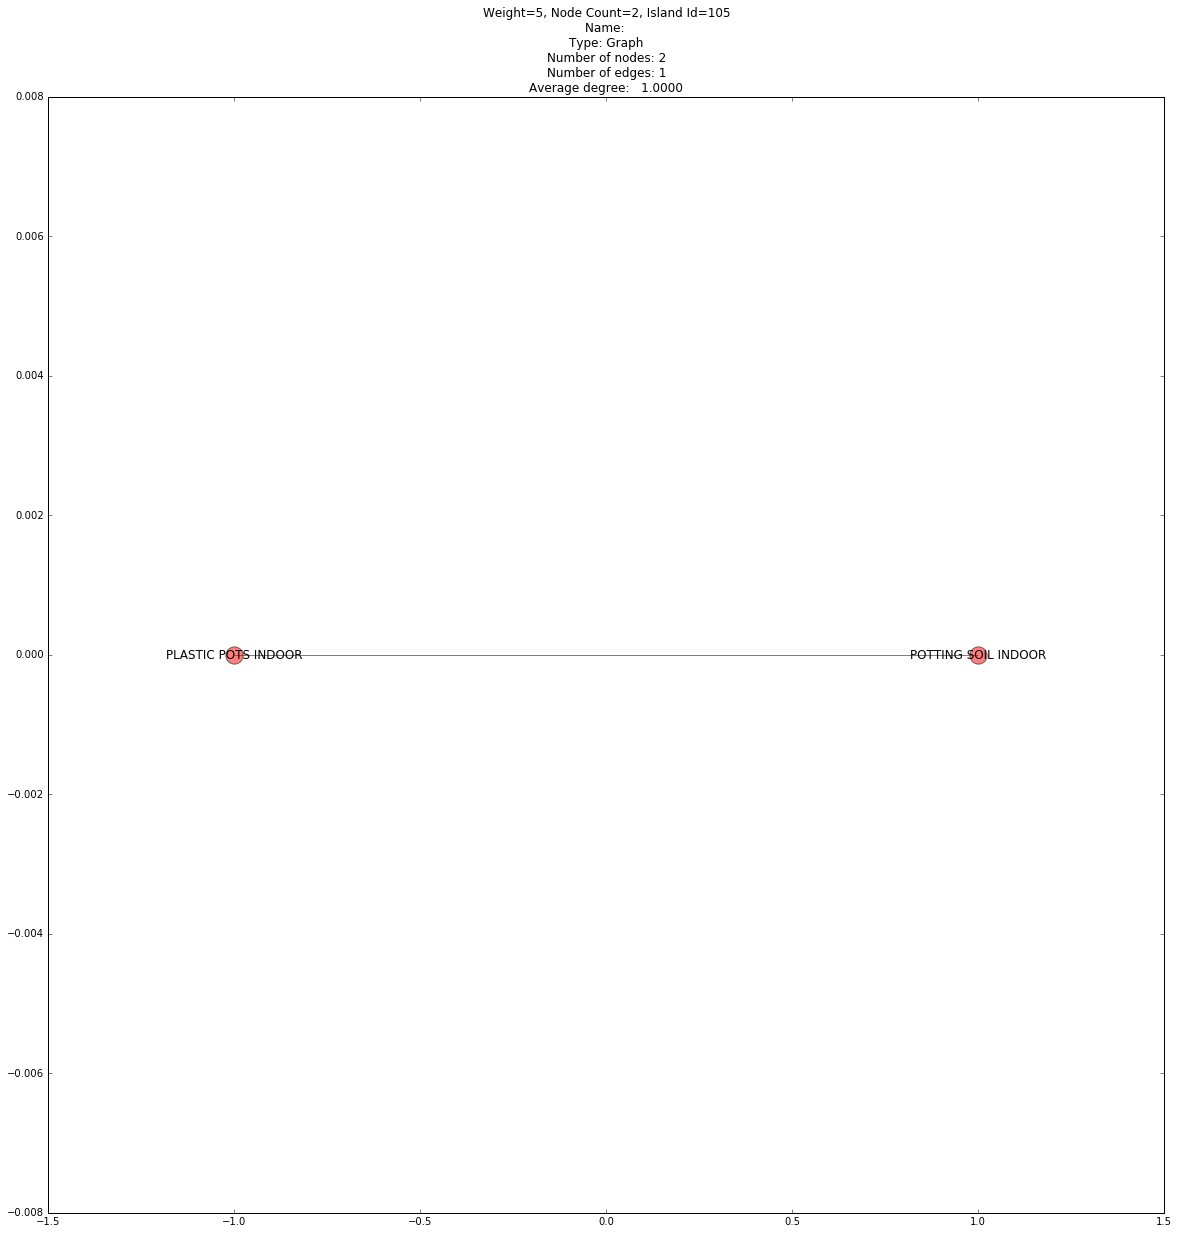

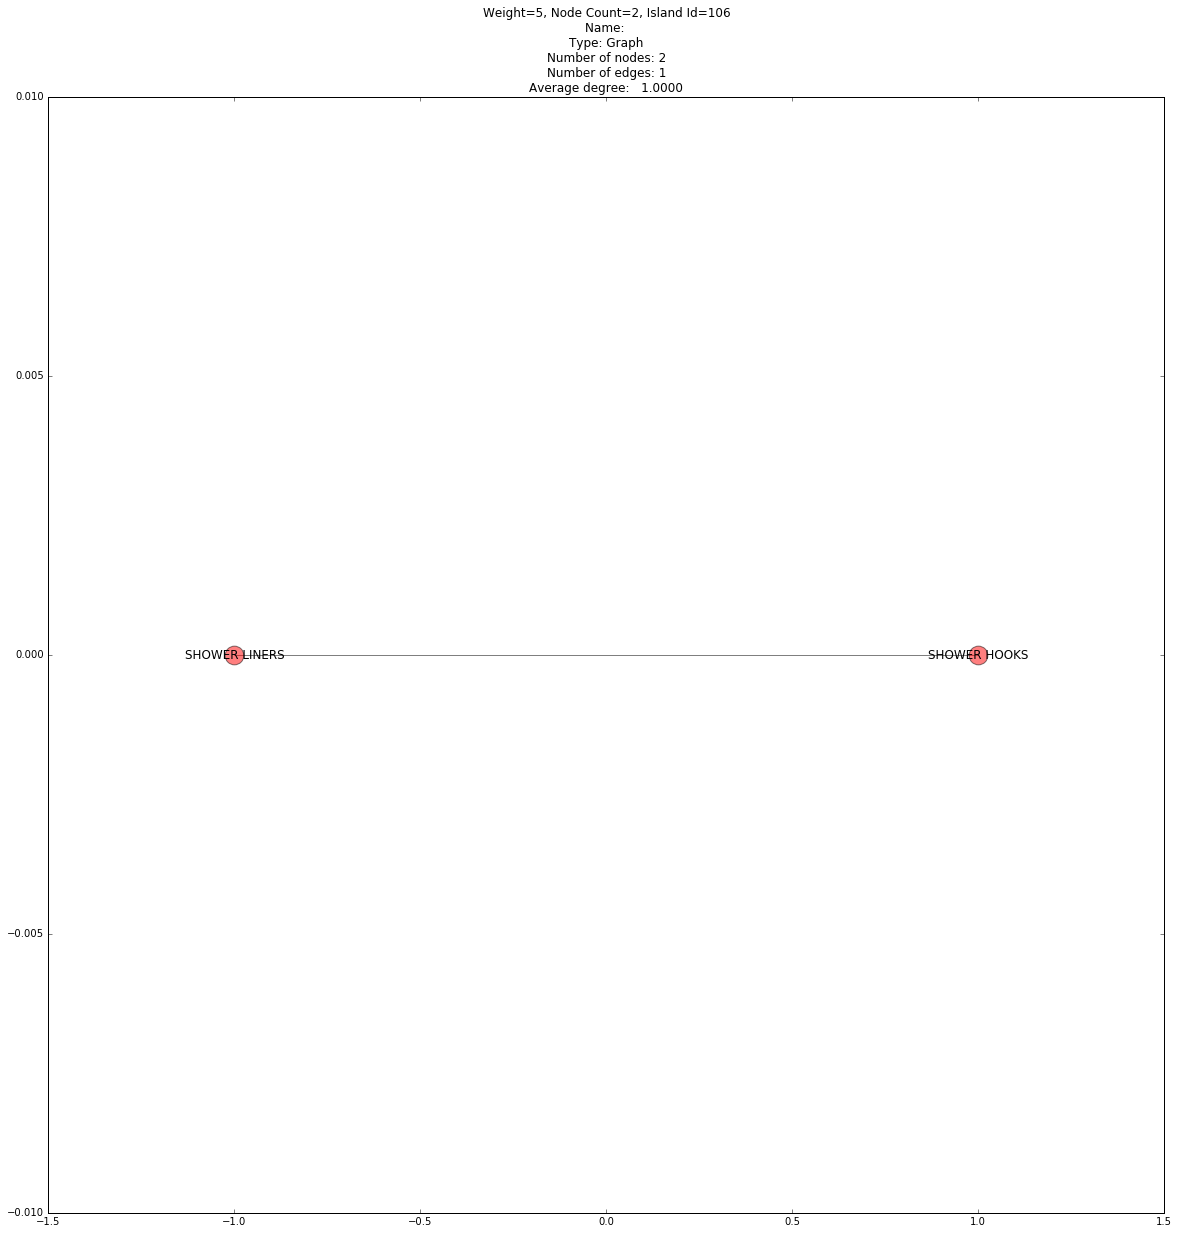

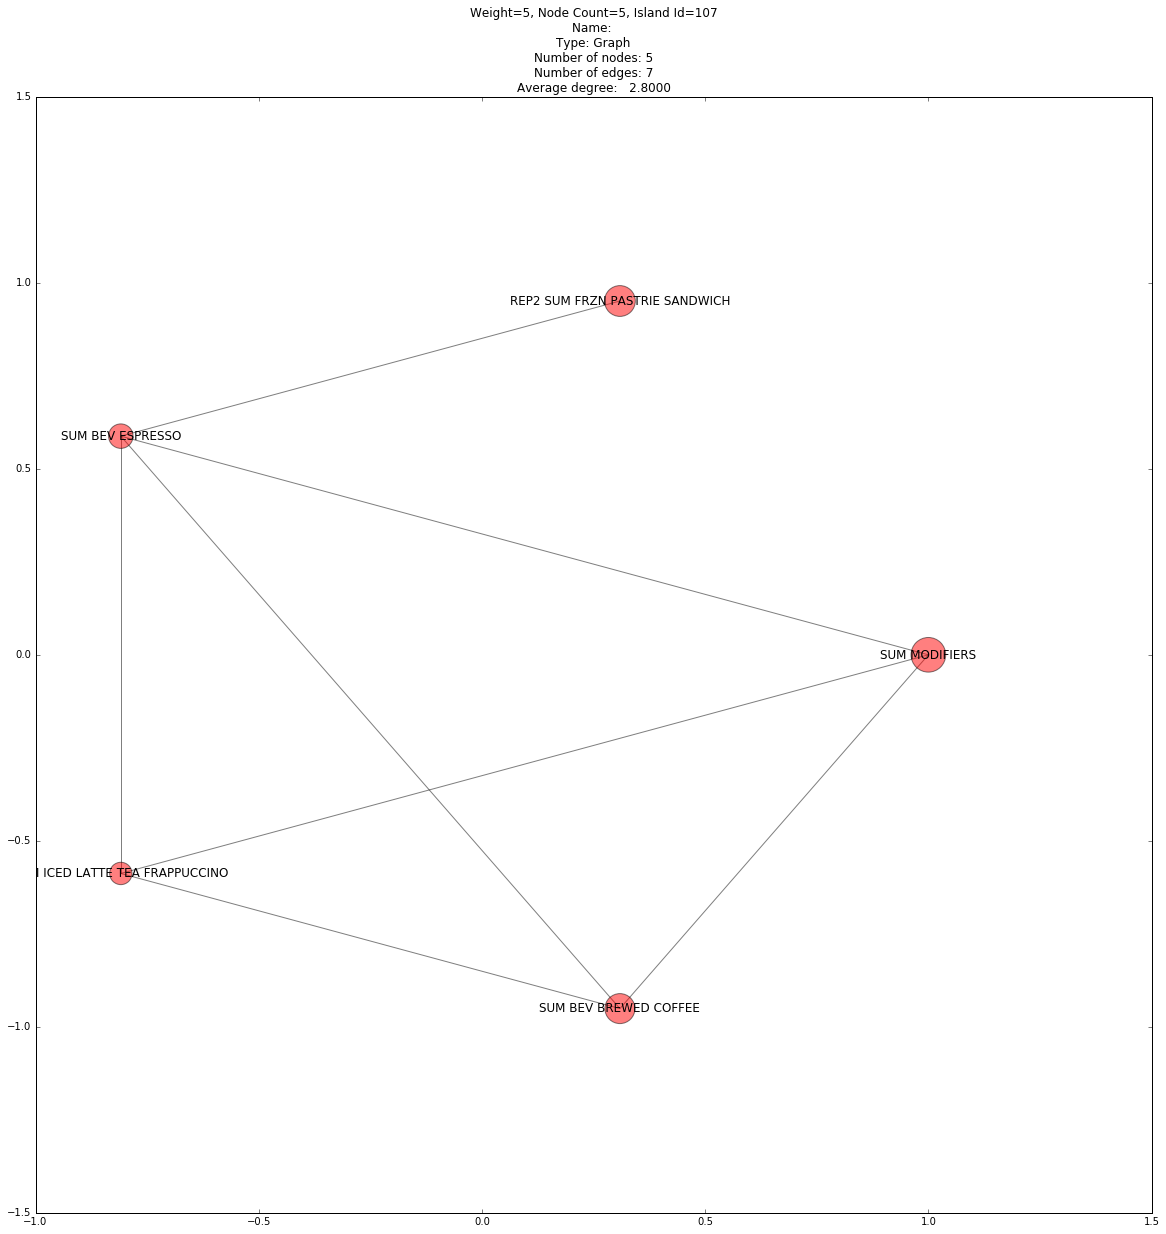

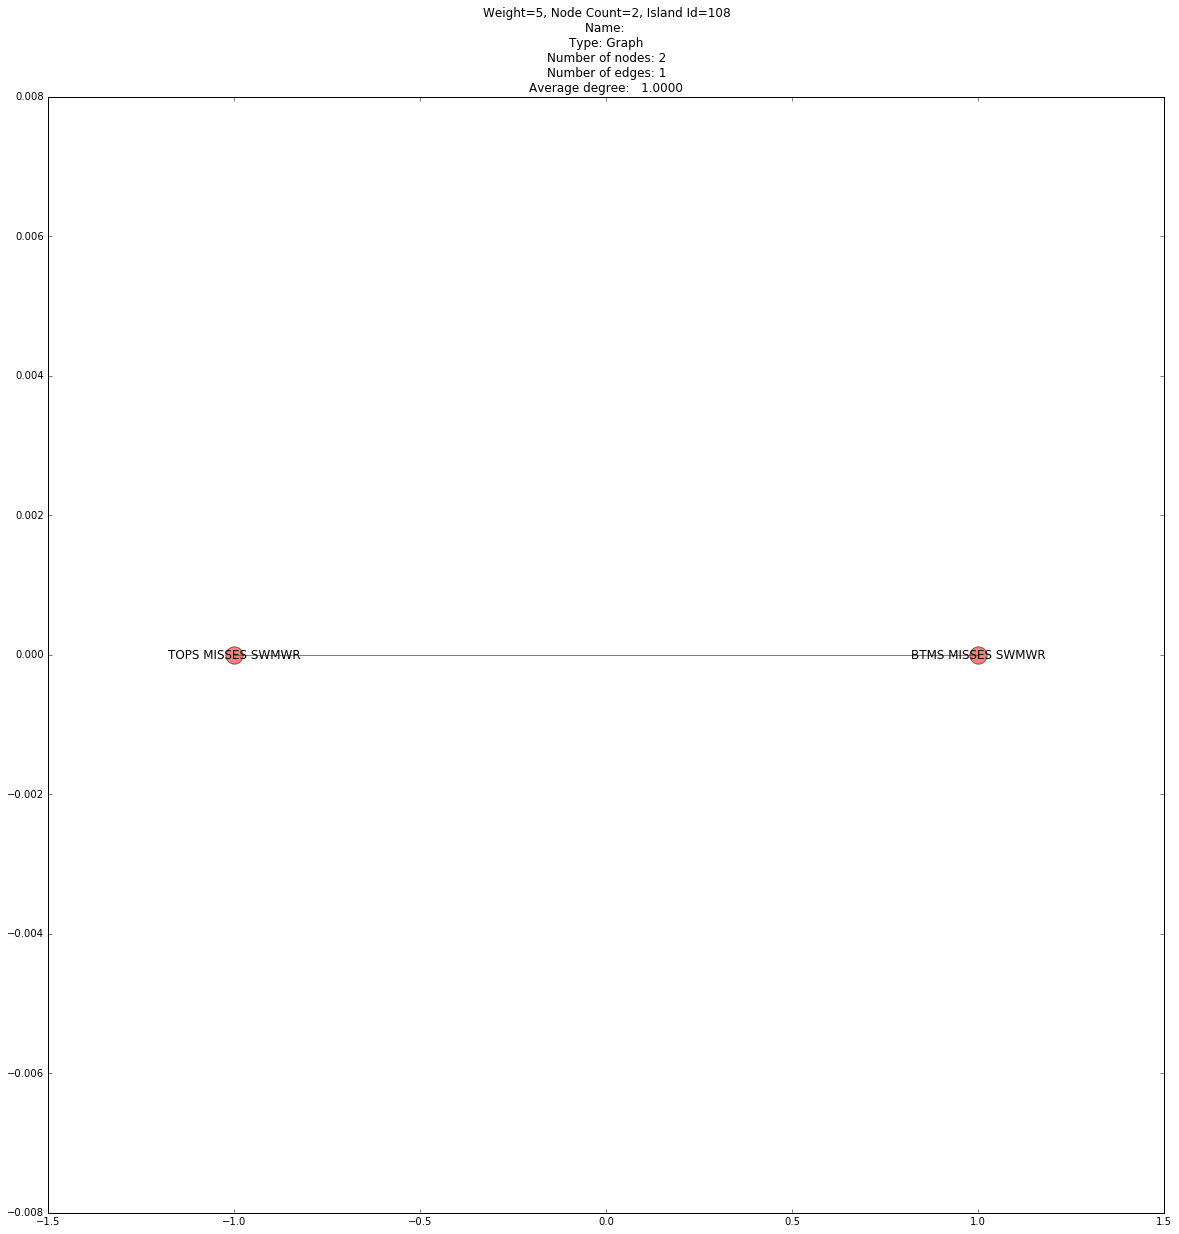

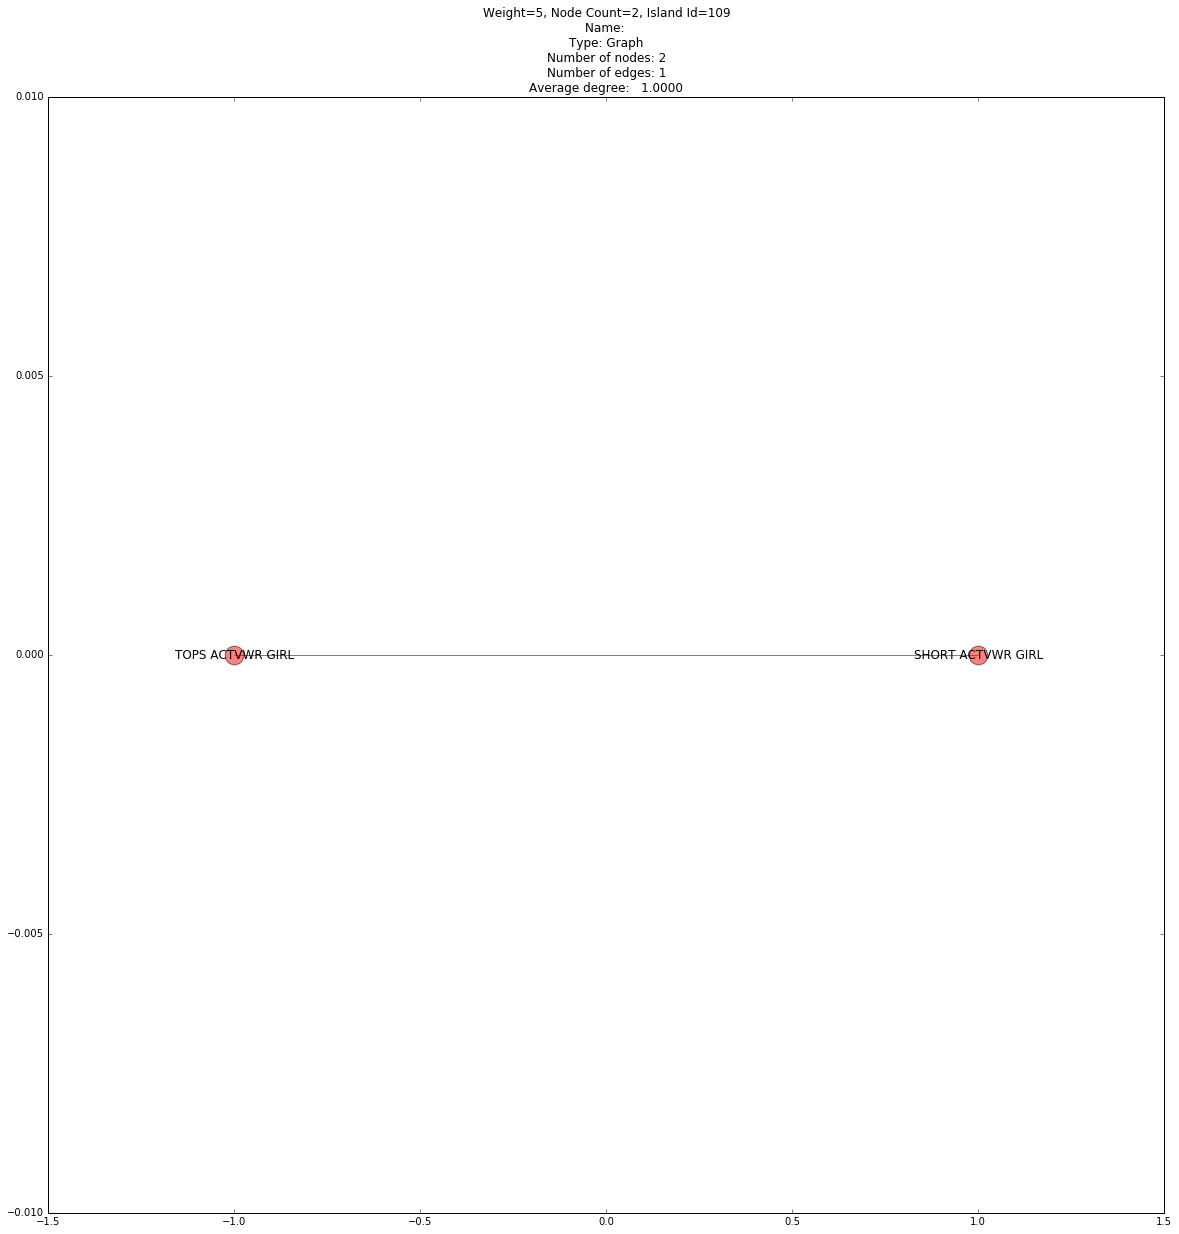

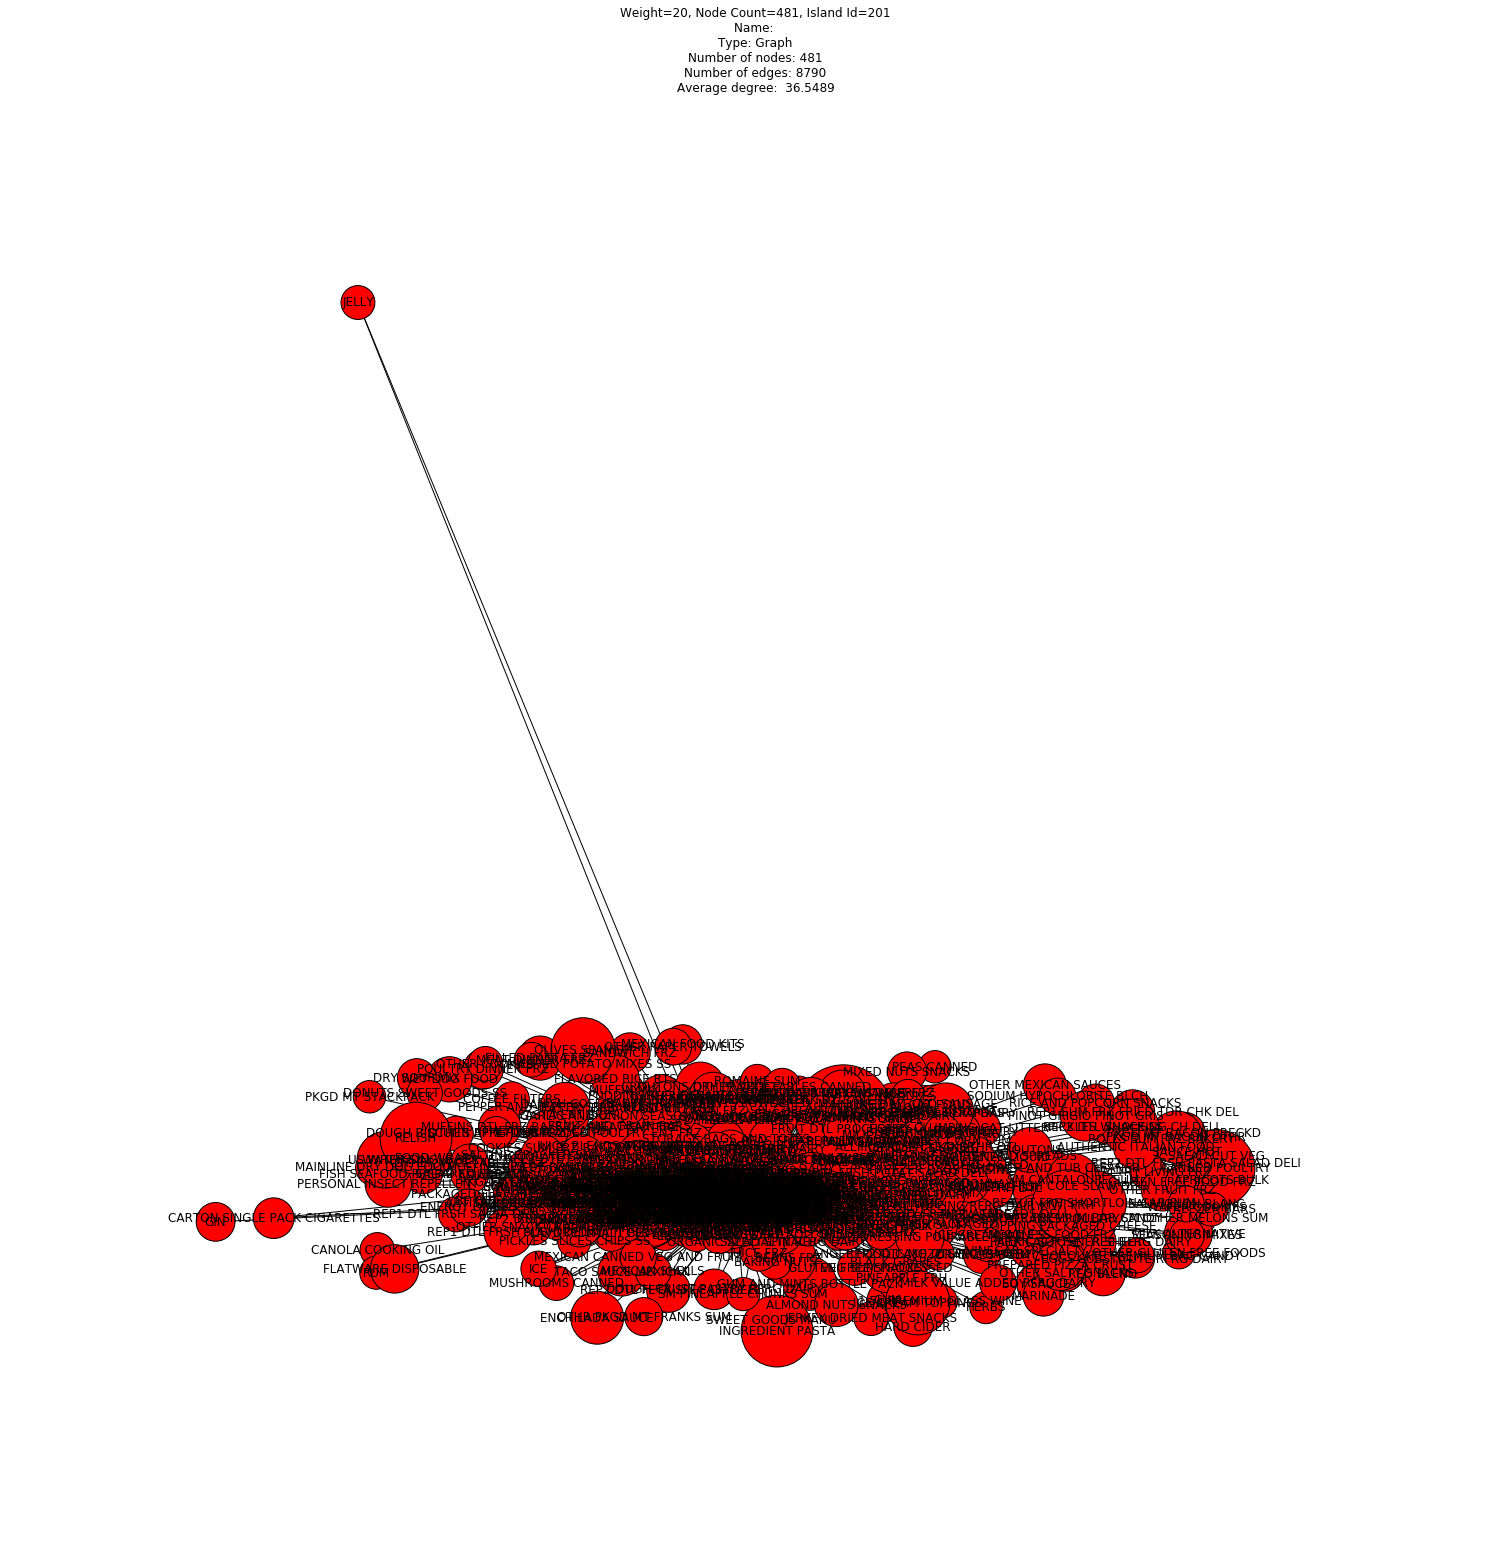

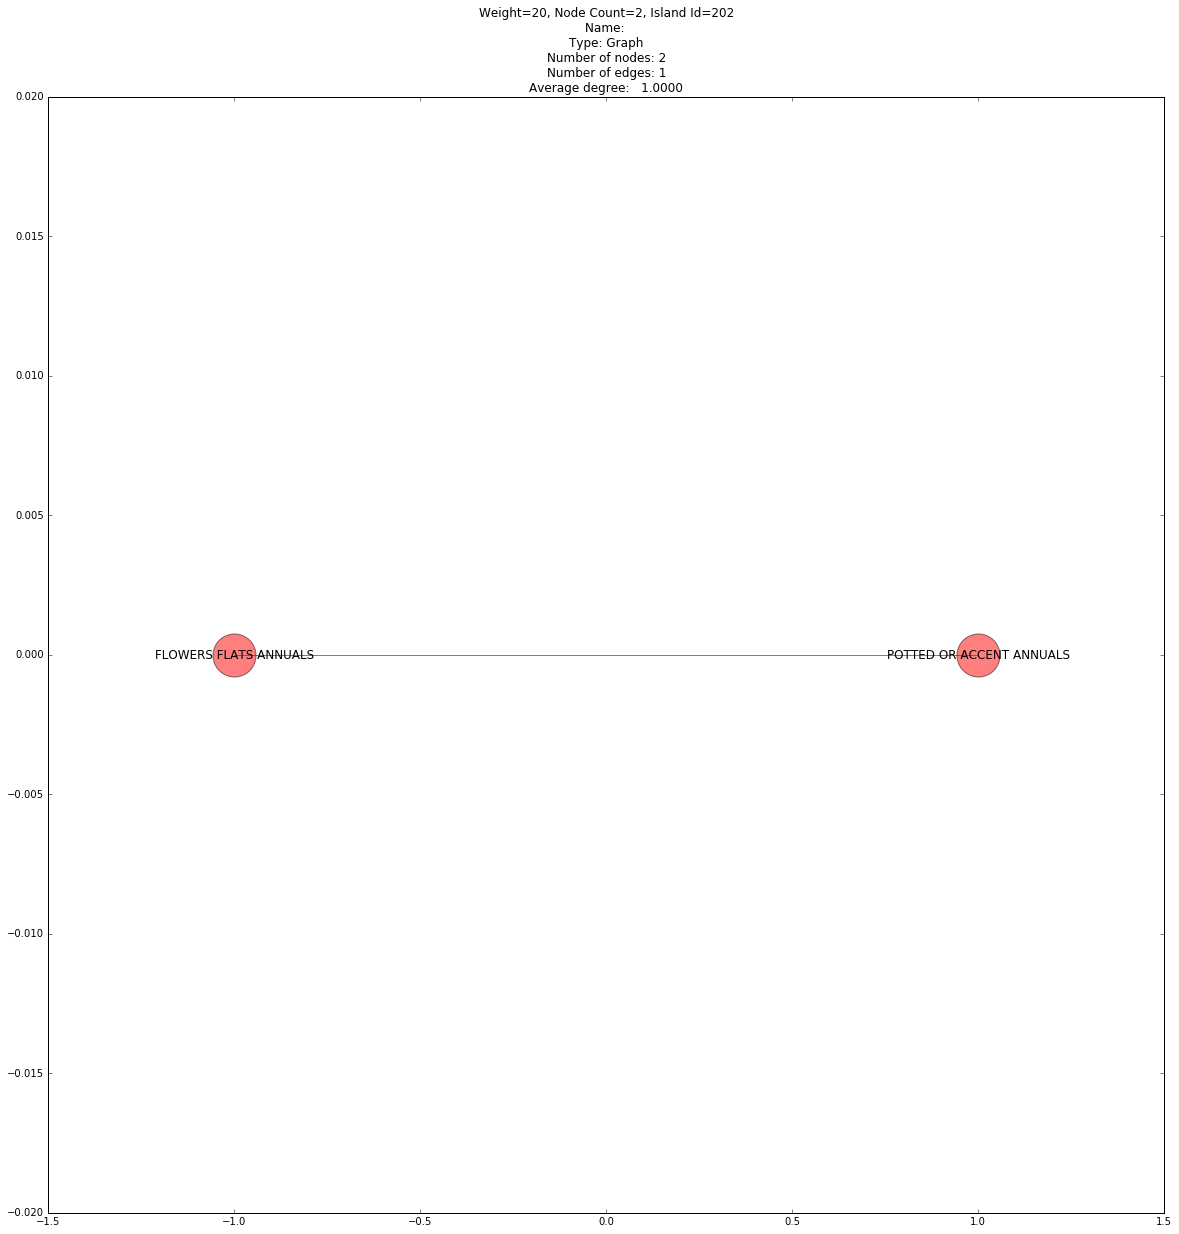

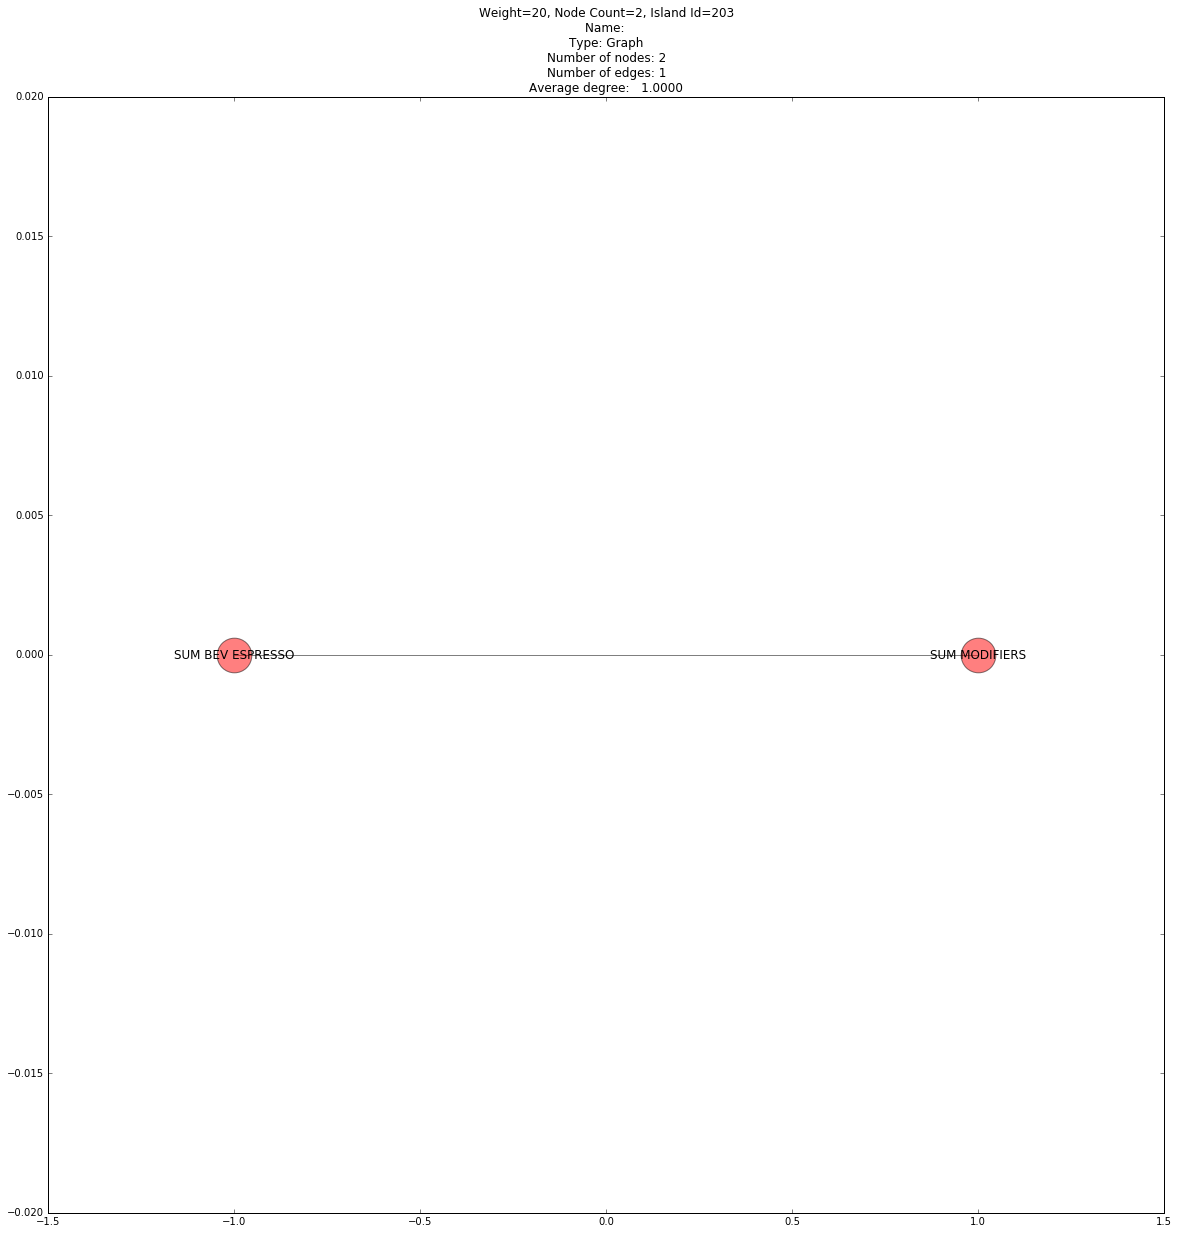

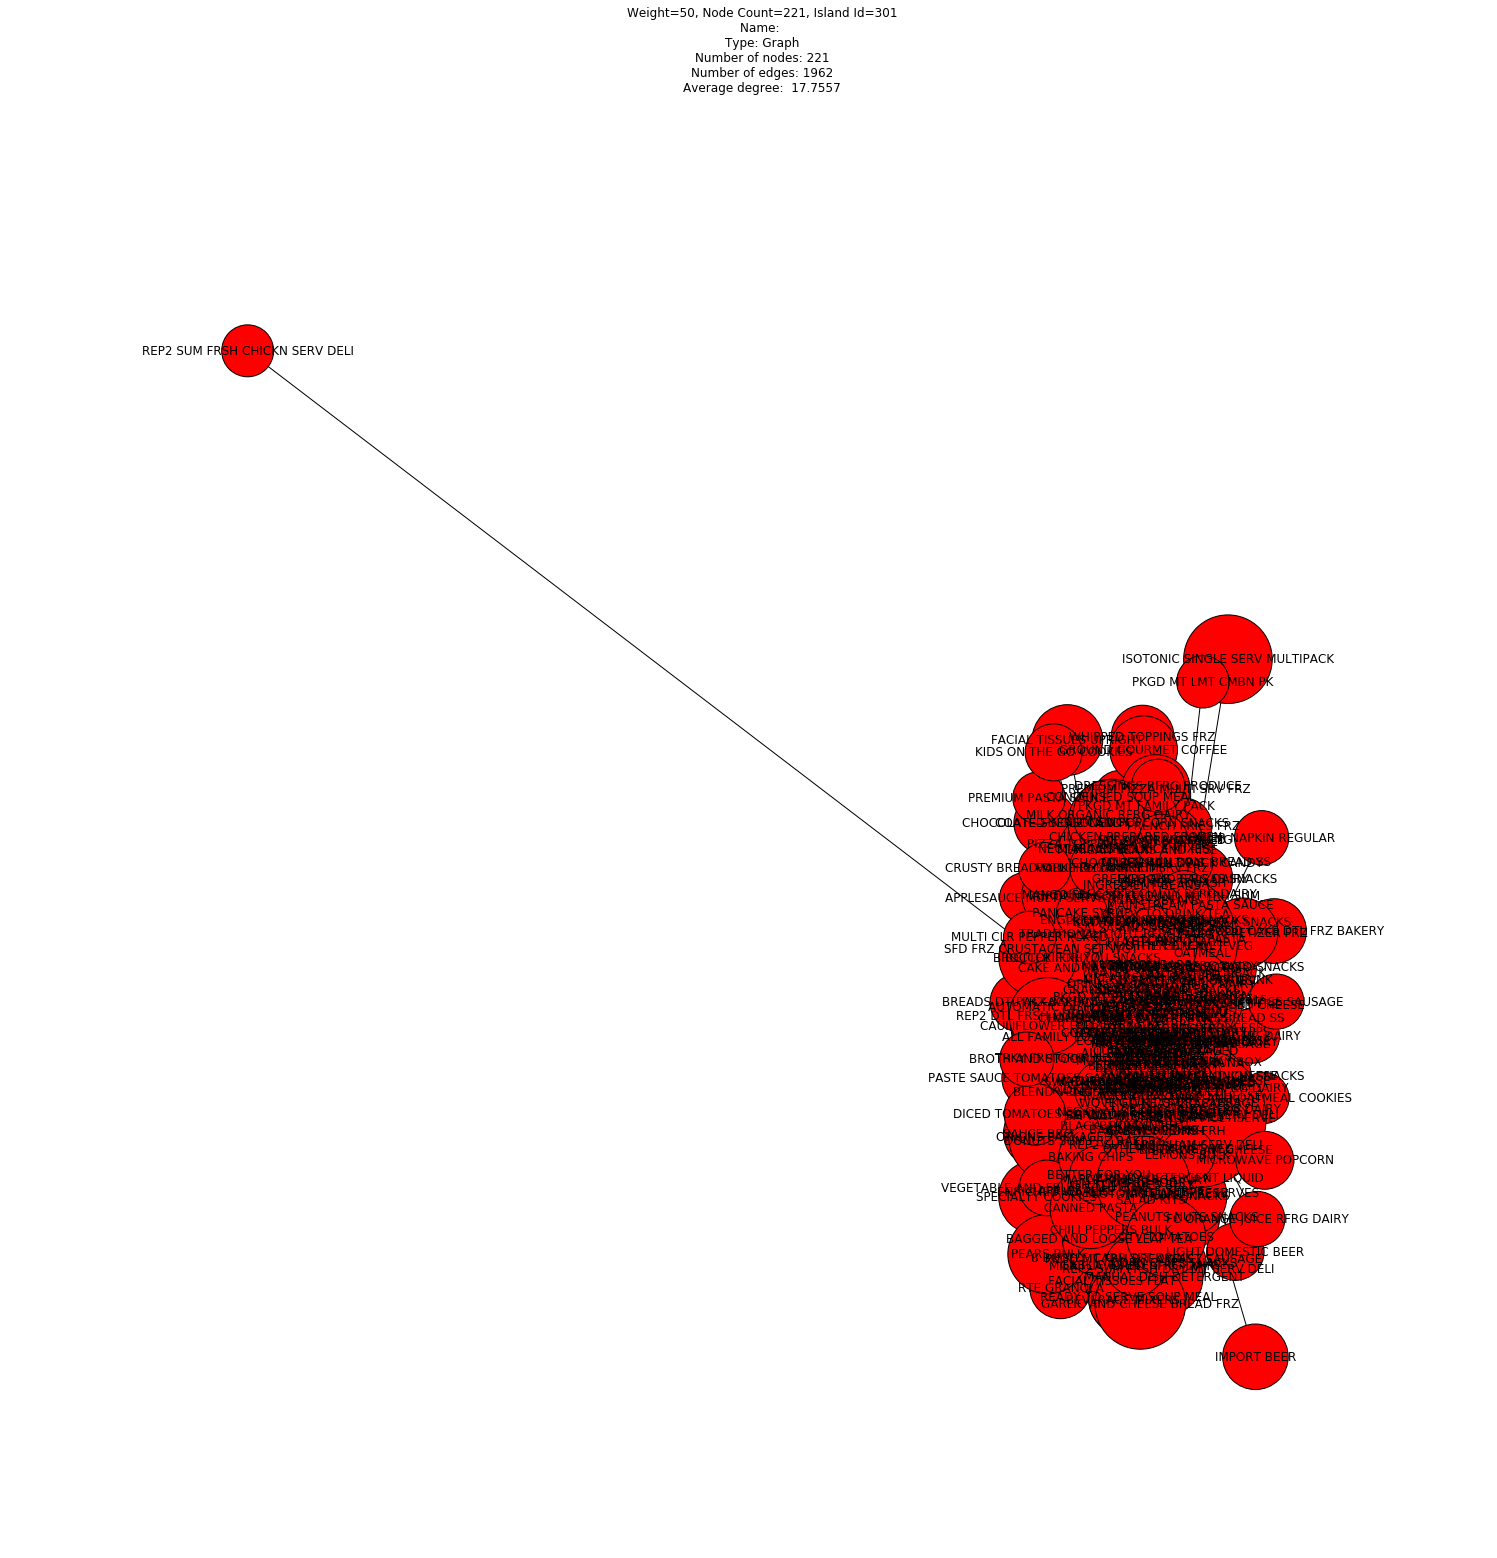

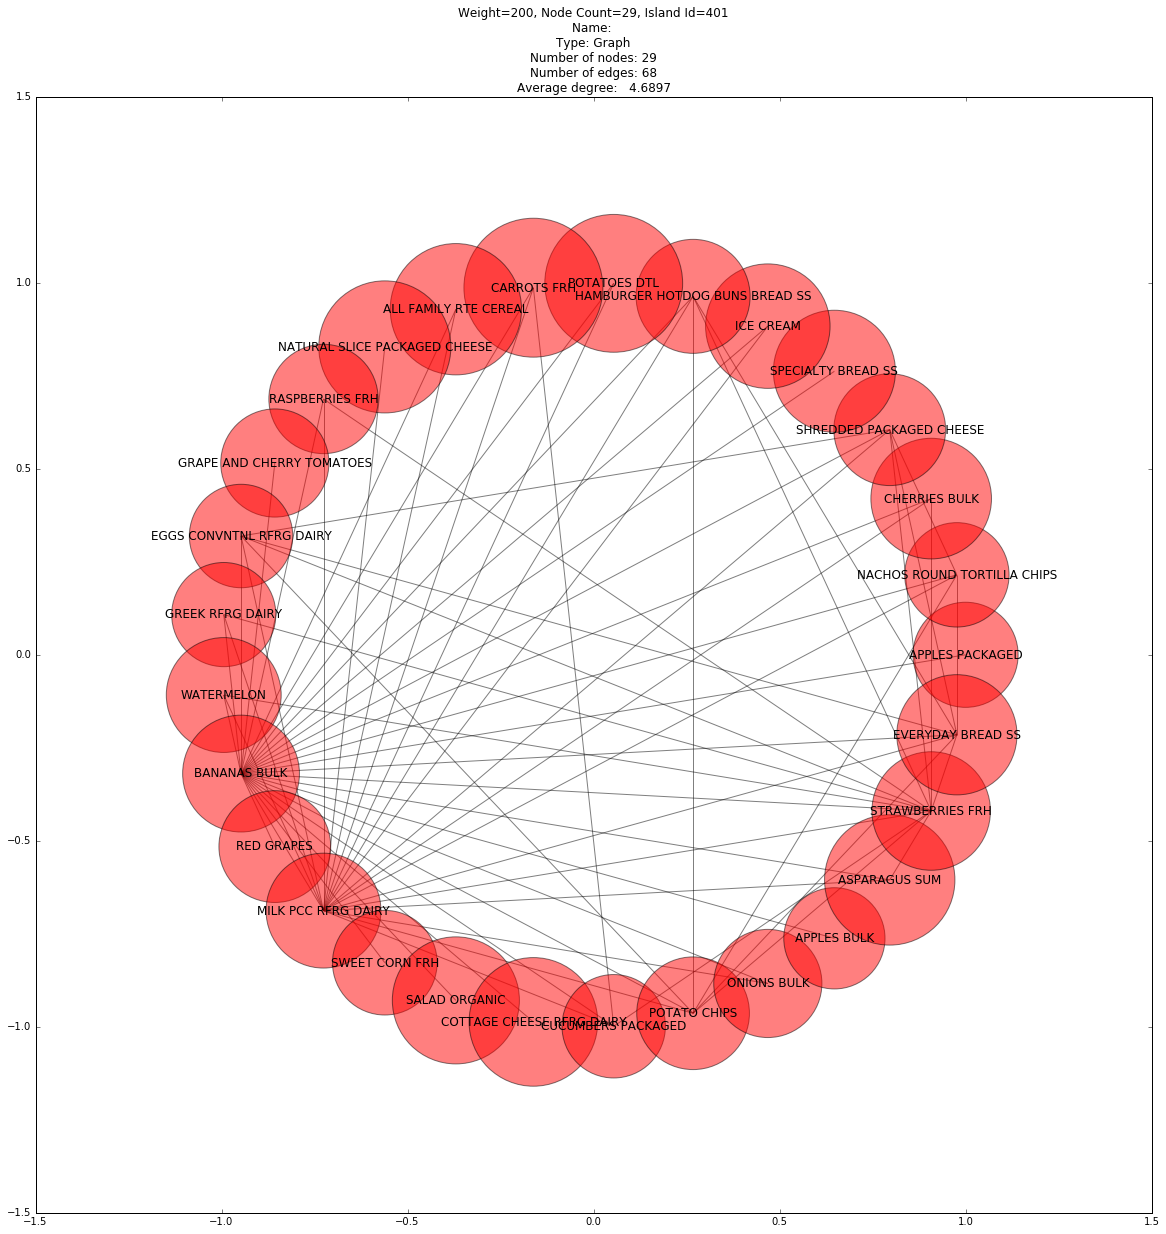

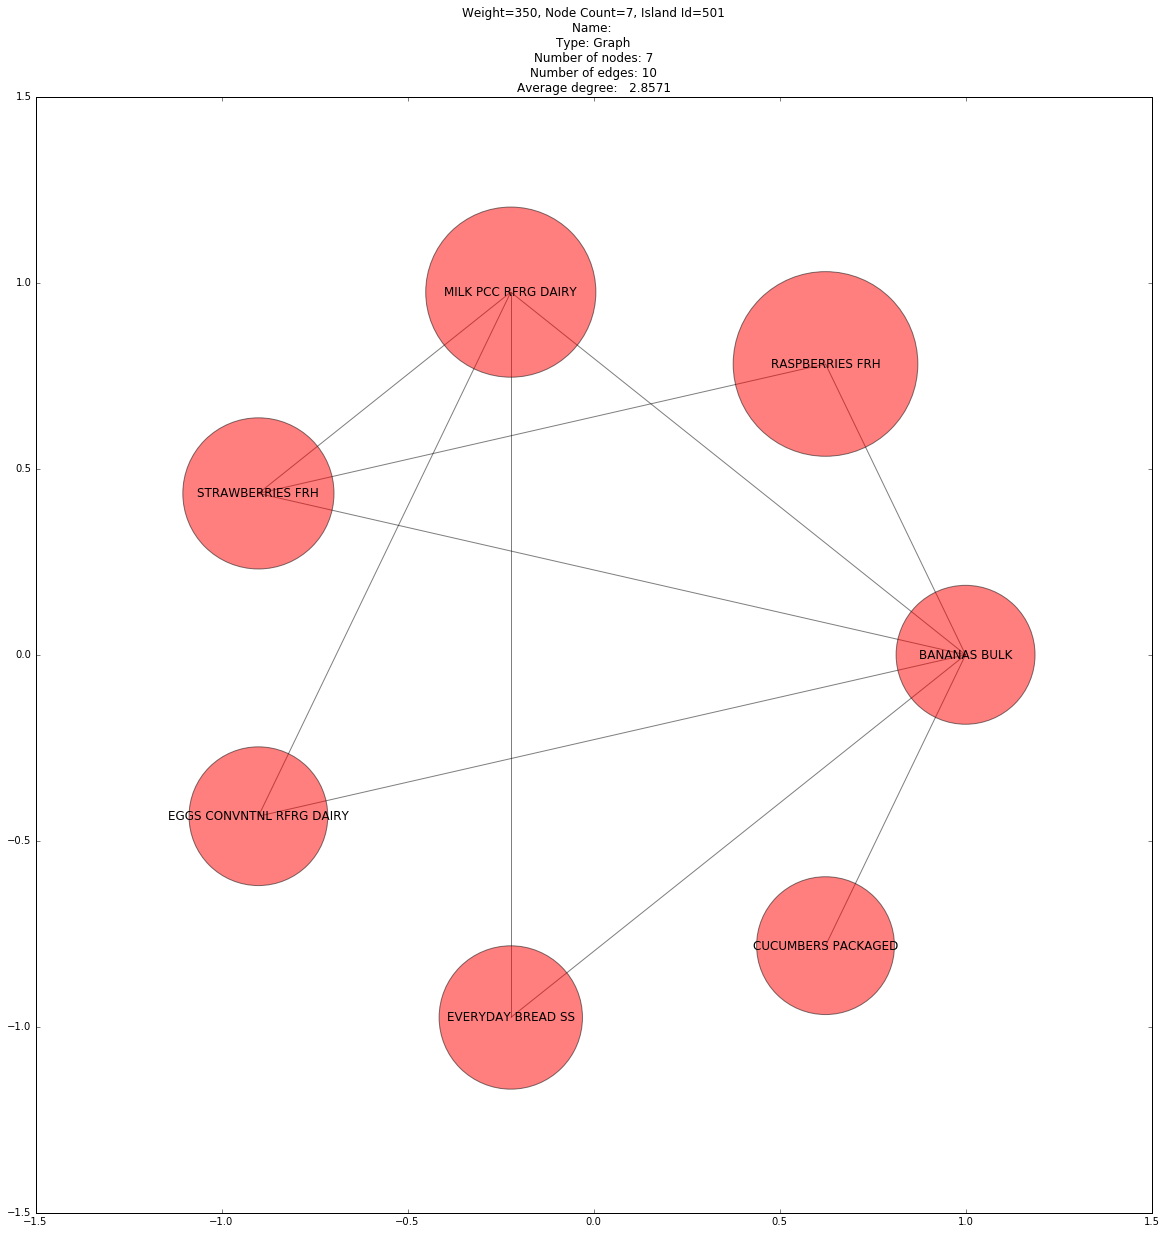

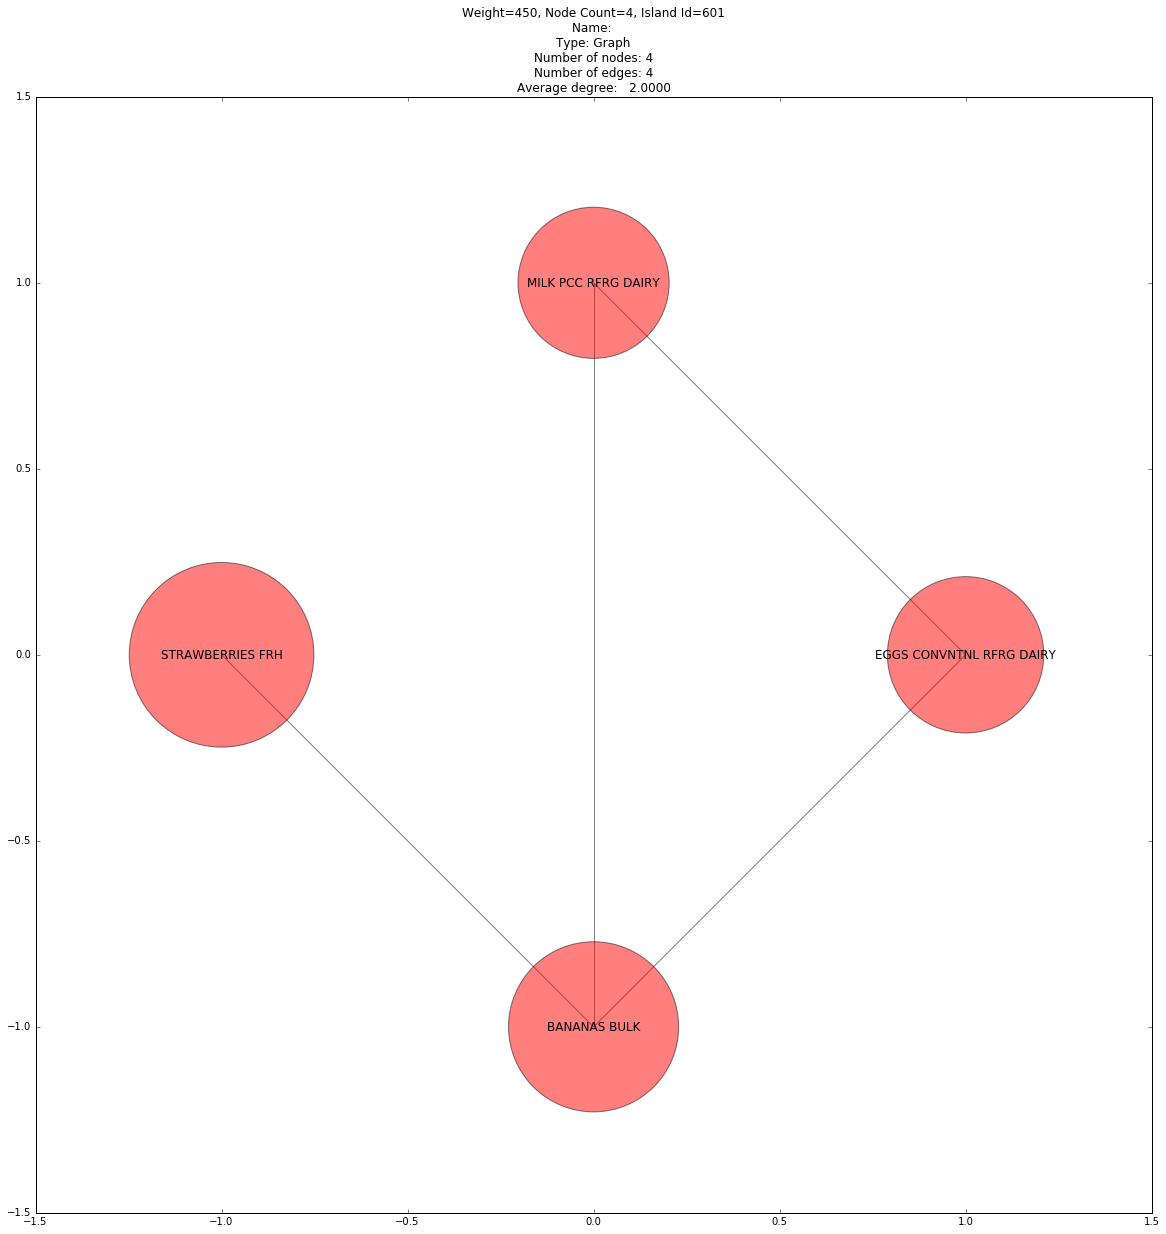

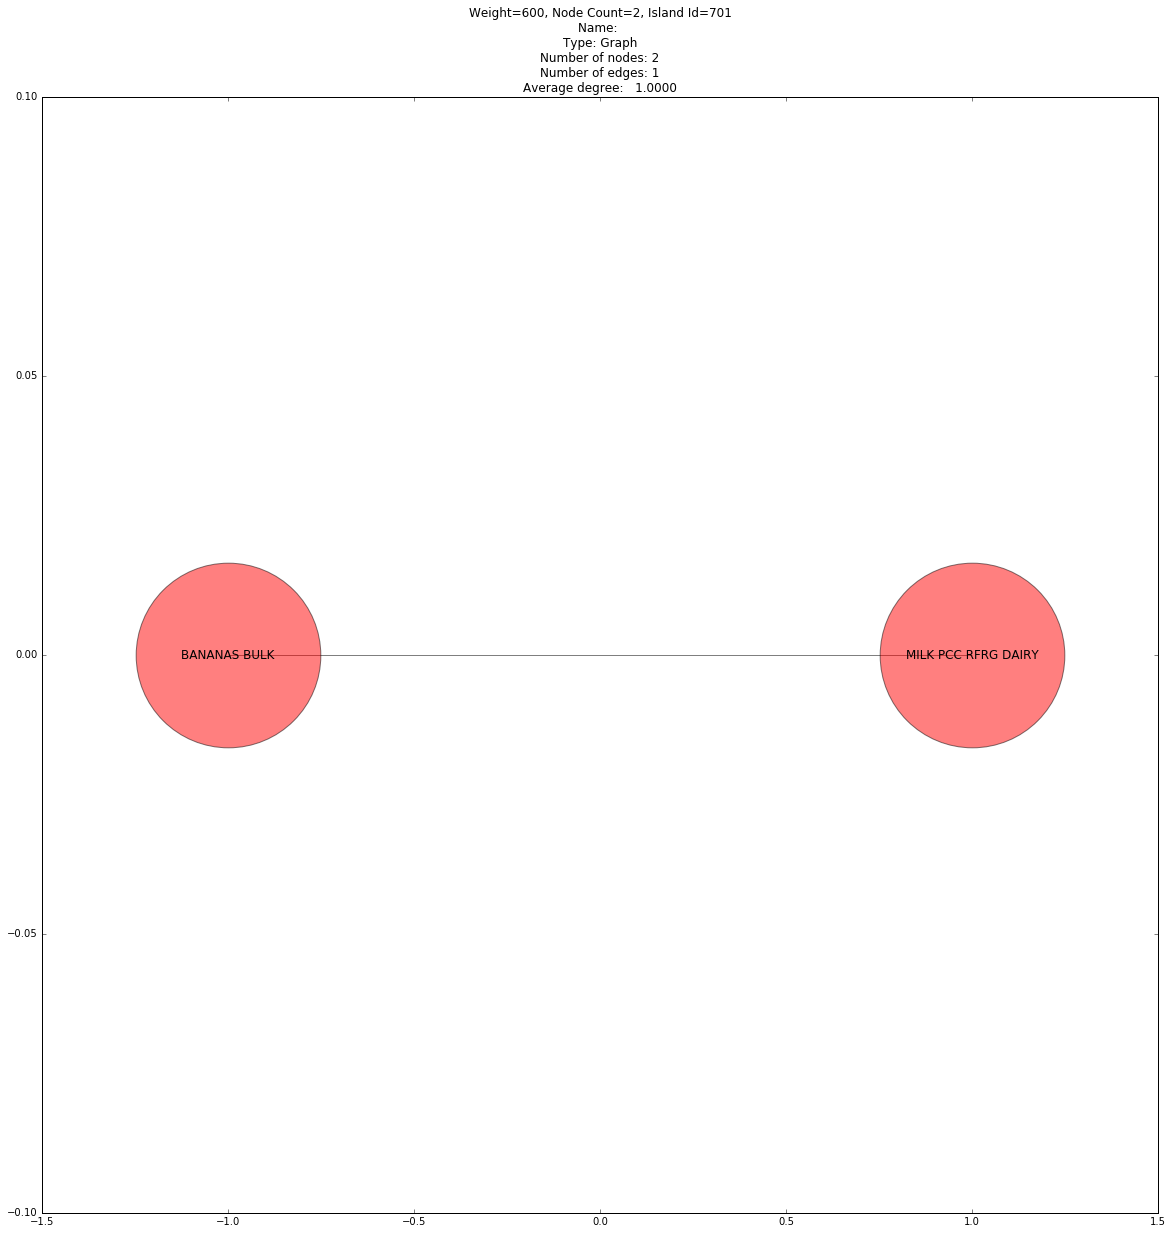

In [26]:
displayIslands(islands)

In [27]:
prod[prod.order_id.isin(prod[prod.product_desc=='ATHL SHOE BOY'].order_id.tolist())].sort_values(by='order_id')

,order_id,product_id,product_desc,cat_desc
4215,11132214,2347473,KIDS RTE CEREAL,READY TO EAT CEREAL
96297,11132214,522110,ALL FAMILY SS JUICE,JUICES AND JUICE DRINKS SS
94229,11132214,797626,NON-COFFEE PODS,COFFEE PODS
92382,11132214,1202760,FABRIC SOFTENER SHEETS,FABRIC SOFTENER
87589,11132214,2704824,CONDENSED SOUP COOKING,CONDENSED SOUP
81742,11132214,3186371,US WHISKEY,WHISKEY
67794,11132214,445257,BEVERAGE MIXERS,BEVERAGE MIXERS
64852,11132214,2944654,ATHL SHOE BOY,KIDS ATHLETIC
64601,11132214,345293,PAPER NAPKIN REGULAR,PAPER NAPKIN
123401,11132214,2767401,WILD BIRD MIXED SEED,WILDBIRD FEEDERS AND FOOD


In [28]:
prod[prod.order_id.isin(prod[prod.product_desc=='PLATES DINNER'].order_id.tolist())].sort_values(by='order_id')

,order_id,product_id,product_desc,cat_desc
31513,11388431,156462,REP2 DTL CHEDDAR SPEC CH DELI,DELI SPECIALTY CHEESE
31826,11388431,2900642,REP2 DTL FRSH DRY MT PRS DELI,DELI PRESLICED MEAT AND CHEESE
39764,11388431,358673,GADGETS SERVING PIECES,KITCHEN GADGETS
49129,11388431,571878,PLATES DINNER,DINNERWARE
55575,11388431,2196361,CRAFT BEER,ABOVE PREMIUM QUALITY BEER
66918,11388431,2777011,MULTI PACKS BATH,BATH TOWELS
77928,11388431,1564058,BOWLS SMALL INDIVIDUAL,DINNERWARE
1091,11575709,982805,TABLE LINENS PLACEMATS,TABLE LINENS
9078,11575709,1563828,SUMMER PLACE SETTINGS,SEASONAL TABLETOP
9079,11575709,2411779,LEGGINGS GIRL,BOTTOMS GIRLS


# Product Recomendations

With the product-product graph we can make product recomendations by looking at the ego network for a given product:


In [29]:
def recommendProductsPR(buying):
    print datetime.datetime.now().time()

    p_id = unique_products[(unique_products.product_desc == buying).tolist()].product_id.tolist()[0]
    E = nx.ego_graph(P,p_id,radius=2)

    #E_d = E.to_directed()
    # Rank elements of network using pagerank
    pr = nx.pagerank(E)
    # set the node attribute
    #nx.set_node_attributes(E_d, 'pagerank_op_1', pr)

    nx.set_node_attributes(E,"pagerank",pr)
    
    E = nx.ego_graph(E,p_id,radius=2)
    nodes = E.nodes(data=True)


    df= pd.DataFrame()
    df = pd.DataFrame([node[1] for node in nodes])
    df['product_id'] = [node[0] for node in nodes]
    
    print datetime.datetime.now().time()

    return df.sort_values(by='pagerank',ascending=False)


recommendProductsPR('VODKA UNFLAVORED').head(20)

11:41:23.066672
11:41:41.387348


,cat_desc,degree_centrality_op,degree_op,pagerank,pagerank_op,product_desc,type,product_id
1033,BANANAS,0.724838,40125,0.014266,0.014110,BANANAS BULK,product,2797511
1067,MILK CONVNTNL RFRG DAIRY,0.684672,33968,0.011982,0.011857,MILK PCC RFRG DAIRY,product,1921107
173,BERRIES,0.640351,26443,0.009265,0.009171,STRAWBERRIES FRH,product,615029
90,EGGS CONVNTNL RFRG DAIRY,0.610803,22519,0.007937,0.007851,EGGS CONVNTNL RFRG DAIRY,product,41272
468,SHREDS AND CHUNKS PKGD CHEESE,0.614958,22098,0.007766,0.007682,SHREDDED PACKAGED CHEESE,product,714380
587,BREAD SS,0.612650,21220,0.007515,0.007435,EVERYDAY BREAD SS,product,1370235
102,SALTY SNACKS,0.633887,20377,0.007364,0.007283,POTATO CHIPS,product,2490747
1746,SALTY SNACKS,0.601570,20128,0.007124,0.007046,NACHOS ROUND TORTILLA CHIPS,product,1522439
2008,CUCUMBERS,0.594183,20084,0.007027,0.006957,CUCUMBERS PACKAGED,product,3383004
377,BUNS AND ROLLS BREAD SS,0.606187,19570,0.006956,0.006883,HAMBURGER HOTDOG BUNS BREAD SS,product,378140


Pagerank does not appear to provide a good related-product ranking. Bananas are at the very top. After trying other measures, let's look at edge_betweenness_centrality

In [30]:
def recommendProductsEBC(buying):
    print datetime.datetime.now().time()

    p_id = unique_products[(unique_products.product_desc == buying).tolist()].product_id.tolist()[0]
    E = nx.ego_graph(P,p_id,radius=1)

    #E_d = E.to_directed()
    # Rank elements of network using pagerank
    pr = nx.edge_betweenness_centrality(E)
    # set the node attribute
    #nx.set_node_attributes(E_d, 'pagerank_op_1', pr)

    nx.set_edge_attributes(E,"edge_betweenness_centrality",pr)
    edges = []
    edges = E.edges(data=True)

    filtered_edges = []

    for e in edges:
        if (e[0]== p_id):
            filtered_edges.append((e[1],e[2]))
        if (e[1]== p_id):
            filtered_edges.append((e[0],e[2]))

    df= pd.DataFrame()
    df = pd.DataFrame([edge[1] for edge in filtered_edges])
    df['product_id'] = [edge[0] for edge in filtered_edges]

    merged = unique_products.merge(df, left_on='product_id',right_on='product_id')
    #merged = merged.merge(unique_products, left_on='dst',right_on='product_id')

    print datetime.datetime.now().time()

    print buying

    return merged.sort_values(by='edge_betweenness_centrality',ascending=False)

recommendProductsEBC('VODKA UNFLAVORED').head(20)

11:41:41.518464
11:43:08.812518
VODKA UNFLAVORED


,product_id,product_desc,cat_desc,count,edge_betweenness_centrality,weight
698,2944654,ATHL SHOE BOY,KIDS ATHLETIC,4,0.000380,1
682,3066207,MAPS,ART,2,0.000330,1
192,877258,CYPRESS MULCH,LANDSCAPING MULCH,7,0.000310,1
692,1912279,LANDSCAPE STONE BAGGED,LANDSCAPING STONE,6,0.000305,1
693,343621,FASHN THONG WMN,WOMENS FASHION PANTIES,3,0.000303,1
619,343470,FASHN BIKINI WMN,WOMENS FASHION PANTIES,3,0.000303,1
694,3157828,SLVS KNITS OB MS,KNIT WOVEN TOPS OB MS,10,0.000240,1
699,3071694,WINDOW TOPPERS,SOFT WINDOW,2,0.000229,1
587,3227327,SHORT SLV WVN MEN,MENS WOVEN TOPS,8,0.000208,1
690,228159,REP2 DTL SWISS CH PSL DELI,DELI PRESLICED MEAT AND CHEESE,3,0.000207,1


As we can see above, this method takes way too long and the ranking is not that good. Let's try a conditional probabilty method where we want to calculate:

P(A and B) = P(A|B) * P(B)

In [31]:
def recommendProductsConditionalP(buying):
    print datetime.datetime.now().time()

    p_id = unique_products[(unique_products.product_desc == buying).tolist()].product_id.tolist()[0]
    E = nx.ego_graph(P,p_id,radius=1)



    p_n = float(unique_products[unique_products.product_id == p_id]['count'].sum())
    edges = []
    edges = E.edges(data=True)

    filtered_edges = []

    for e in edges:
        if (e[0]== p_id):
            filtered_edges.append((e[1],e[2]['weight'],p_n,float(unique_products[unique_products.product_id == e[1]]['count'].sum())))
        if (e[1]== p_id):
            filtered_edges.append((e[0],e[2]['weight'],p_n,float(unique_products[unique_products.product_id == e[0]]['count'].sum())))

    df= pd.DataFrame()
    df = pd.DataFrame([edge for edge in filtered_edges])
    df.columns = ['product_id','weight','p_n','op_n']
    df['score'] = df.weight/df.op_n * df.op_n/(df.p_n+df.op_n)

    #df['product_id'] = [edge[0] for edge in filtered_edges]

    merged = unique_products.merge(df, left_on='product_id',right_on='product_id')
    #merged = merged.merge(unique_products, left_on='dst',right_on='product_id')

    print datetime.datetime.now().time()

    print buying

    return merged.sort_values(by='score',ascending=False)

recommendProductsConditionalP('VODKA UNFLAVORED').head(20)

11:43:08.919605
11:43:10.759416
VODKA UNFLAVORED


,product_id,product_desc,cat_desc,count,weight,p_n,op_n,score
148,445257,BEVERAGE MIXERS,BEVERAGE MIXERS,210,35,218.0,210.0,0.081776
74,1009519,SPIRIT MIXERS,SPIRIT MIXERS,89,13,218.0,89.0,0.042345
495,1179276,6 CAN CARB SFT DRINK,CARBONATED SOFT DRINKS,142,15,218.0,142.0,0.041667
440,3186371,US WHISKEY,WHISKEY,123,14,218.0,123.0,0.041056
186,596368,LIMES BULK,CITRUS,356,23,218.0,356.0,0.040070
290,2365893,RUM,ALL OTHER LIQUOR,129,13,218.0,129.0,0.037464
425,2181100,GIN,ALL OTHER LIQUOR,52,10,218.0,52.0,0.037037
128,895195,LIGHT DOMESTIC BEER,PREMIUM QUALITY BEER,366,21,218.0,366.0,0.035959
36,264369,SPARKLING WATER,ENHANCED WATER,504,23,218.0,504.0,0.031856
386,3241793,AVOCADOS BULK,AVOCADOS,417,19,218.0,417.0,0.029921


The recomendations seem very reasonable. Let's look at other product predictions:

In [32]:
recommendProductsConditionalP('TOILET PAPER').head(20)


11:43:10.814006
11:43:14.581241
TOILET PAPER


,product_id,product_desc,cat_desc,count,weight,p_n,op_n,score
317,1838899,CHOOSE A SIZE PAPER TOWELS,PAPER TOWELS,324,113,575.0,324.0,0.125695
3,1921107,MILK PCC RFRG DAIRY,MILK CONVNTNL RFRG DAIRY,1802,191,575.0,1802.0,0.080353
261,1033466,LAUNDRY DETERGENT LIQUID,LAUNDRY DETERGENT,299,70,575.0,299.0,0.080092
60,714380,SHREDDED PACKAGED CHEESE,SHREDS AND CHUNKS PKGD CHEESE,967,109,575.0,967.0,0.070687
79,2797511,BANANAS BULK,BANANAS,2140,185,575.0,2140.0,0.068140
49,1522439,NACHOS ROUND TORTILLA CHIPS,SALTY SNACKS,965,104,575.0,965.0,0.067532
271,1442227,BUTTER RFRG DAIRY,BUTTER MARGARINE SPREAD RFRG,504,72,575.0,504.0,0.066728
54,2917751,PLATES DISPOSABLE,DISPOSABLE DISHES,348,61,575.0,348.0,0.066089
68,1370235,EVERYDAY BREAD SS,BREAD SS,1048,107,575.0,1048.0,0.065927
374,41272,EGGS CONVNTNL RFRG DAIRY,EGGS CONVNTNL RFRG DAIRY,1096,109,575.0,1096.0,0.065230


In [33]:
recommendProductsConditionalP('SHORT SLV KNIT GIRL').head(20)

11:43:14.660187
11:43:15.008365
SHORT SLV KNIT GIRL


,product_id,product_desc,cat_desc,count,weight,p_n,op_n,score
243,2525275,SKIRTS GIRL,BOTTOMS GIRLS,7,5,22.0,7.0,0.172414
159,1906278,TOPS ACTVWR GIRL,ACTIVEWEAR GIRLS,11,4,22.0,11.0,0.121212
215,2411779,LEGGINGS GIRL,BOTTOMS GIRLS,5,3,22.0,5.0,0.111111
224,318889,SHORT GIRL,SHORTS GIRLS,8,3,22.0,8.0,0.100000
211,900624,SHORT ACTVWR GIRL,ACTIVEWEAR GIRLS,13,3,22.0,13.0,0.085714
234,1719024,BRIEF GIRL UNDRWR,KIDS UNDERWEAR,3,2,22.0,3.0,0.080000
180,921148,BRAS GIRL UNDRWR,KIDS UNDERWEAR,7,2,22.0,7.0,0.068966
228,284357,TOPS SHORT SLV KNIT BOY,TOPS NB INF TDLR,18,2,22.0,18.0,0.050000
220,950883,LIGHTING RPLCMNT SHADES,LIGHTING,1,1,22.0,1.0,0.043478
246,2306572,GOWNS DORMS GIRL,KIDS SLEEPWEAR,1,1,22.0,1.0,0.043478


In [34]:
recommendProductsConditionalP('BANANAS BULK').head(20)

11:43:15.036249
11:43:19.045976
BANANAS BULK


,product_id,product_desc,cat_desc,count,weight,p_n,op_n,score
3,1921107,MILK PCC RFRG DAIRY,MILK CONVNTNL RFRG DAIRY,1802,682,2140.0,1802.0,0.173009
33,615029,STRAWBERRIES FRH,BERRIES,1373,579,2140.0,1373.0,0.164816
392,41272,EGGS CONVNTNL RFRG DAIRY,EGGS CONVNTNL RFRG DAIRY,1096,457,2140.0,1096.0,0.141224
74,3383004,CUCUMBERS PACKAGED,CUCUMBERS,879,411,2140.0,879.0,0.136138
90,85036,RASPBERRIES FRH,BERRIES,879,386,2140.0,879.0,0.127857
71,1370235,EVERYDAY BREAD SS,BREAD SS,1048,385,2140.0,1048.0,0.120765
256,3276705,CARROTS FRH,COOKING VEGETABLES,680,340,2140.0,680.0,0.120567
66,1584572,GREEK RFRG DAIRY,YOGURT RFRG DAIRY,741,339,2140.0,741.0,0.117667
63,714380,SHREDDED PACKAGED CHEESE,SHREDS AND CHUNKS PKGD CHEESE,967,345,2140.0,967.0,0.111040
0,3314604,CHERRIES BULK,CHERRIES,871,333,2140.0,871.0,0.110594


In [35]:
recommendProductsConditionalP('PLASTIC POTS INDOOR').head(20)

11:43:19.134211
11:43:19.347052
PLASTIC POTS INDOOR


,product_id,product_desc,cat_desc,count,weight,p_n,op_n,score
31,2656114,CERAMIC POTS INDOOR,PLANTERS,9,4,20.0,9.0,0.137931
117,2442621,POTTING SOIL INDOOR,PLANT AND FLORAL ACCESSORIES,31,6,20.0,31.0,0.117647
135,1717654,CLAY CERAMIC PLANTER OUTDOOR,PLANTERS,10,2,20.0,10.0,0.066667
133,2902460,PRUNERS,OUTDOOR HAND TOOLS,17,2,20.0,17.0,0.054054
109,1479501,PLASTIC PLANTERS OUTDOOR,PLANTERS,18,2,20.0,18.0,0.052632
132,2296901,WIND CHIMES,LAWN ORNAMENTS,2,1,20.0,2.0,0.045455
127,2568084,SEED STARTING ACCS AND SOIL,SEED STARTER AND BULBS,4,1,20.0,4.0,0.041667
128,854384,SPECIALTY OUTDOOR HAND TOOLS,OUTDOOR HAND TOOLS,4,1,20.0,4.0,0.041667
20,1171127,TOP SOIL,LANDSCAPING SOIL,30,2,20.0,30.0,0.040000
131,3023501,CAT FLEA AND TICK,CAT TOYS TREATS AND ACCS,5,1,20.0,5.0,0.040000


# Conclusion

* Top Rakning Products: We showed that pagerank is a good metric to rank single-product baskets, with Cigarretes being a top-ranking trip-driver. Degree centrality is a good measure more closely correlated with gross volume, with Bananas having the highest centrality by this measure.
* Product Islands/Communities: By using the island method, we were able to identify top trip drivers.
* Product Recommendations: We struggled identifying centrality measures that were both timely and effective in properly ranking related products. Using basic conditional probability formulas, we were able to calculate an effective measure that ranks related products
